In [1]:
################################################################################################
# 
#       2020.1.8
#       -----------
#       siameseNet 网络test
#       1. 图像增强 https://blog.csdn.net/weixin_40793406/article/details/84867143
#       https://www.pytorchtutorial.com/pytorch-one-shot-learning/#Contrastive_Loss_function
# 
################################################################################################

import sys
sys.path.append('..')

import PIL
from PIL import Image

from torchvision import transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

image_width = 200
image_height = 200

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # 输入为 100 x 100
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            # 对每个 channel 按照概率设置为 0
            nn.Dropout2d(p=.2),
            # 输出为 4 * 100 * 100
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            # 输出为 8 * 100 * 100

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            # 输出为 8 * 100 * 100
        )

        self.fc1 = nn.Sequential(
            # nn.Linear(8*100*100, 500),
            nn.Linear(8*image_width*image_height, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        # self.margin = torch.from_numpy(margin)
        self.margin = torch.tensor([margin])

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        # temp = self.margin - euclidean_distance
        # loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2)
        #                             (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = ((1 - label) * torch.pow(euclidean_distance, 2)
                        + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        return loss_contrastive

In [3]:

class SiameseNetworkDataset():
    __set_size__ = 90
    __batch_size__ = 10

    def __init__(self,set_size=90,batch_size=10,transform=None,should_invert=False):
        self.imageFolderDataset = []
        self.train_dataloader = []

        self.__set_size__ = set_size
        self.__batch_size__ = batch_size

        self.transform = tfs.Compose([
                            tfs.Resize((image_height,image_width)),
                            # tfs.RandomHorizontalFlip(),
                            # tfs.RandomCrop(128),
                            tfs.ToTensor()
                        ])
        self.should_invert = should_invert
        
    def __getitem__(self, class_num=40):
        '''
        如果图像来自同一个类，标签将为0，否则为1
        TODO: 由于classed_pack 每类可能有2-3张, 此时参数item_num无效,故删去参数中的item_num
        '''
        data0 = torch.empty(0, 3, image_width, image_height)
        data1 = torch.empty(0, 3, image_width, image_height)

        should_get_same_class = random.randint(0,1)
        for i in range(self.__batch_size__):
            img0_class = random.randint(0,class_num-1)
            #we need to make sure approx 50% of images are in the same class
            
            if should_get_same_class:
                item_num = len(self.imageFolderDataset[img0_class])
                temp = random.sample(list(range(0,item_num)), 2)
                img0_tuple = (self.imageFolderDataset[img0_class][temp[0]], img0_class)
                img1_tuple = (self.imageFolderDataset[img0_class][temp[1]], img0_class)
            else:
                img1_class = random.randint(0, class_num - 1)
                # 保证属于不同类别
                while img1_class == img0_class:
                    img1_class = random.randint(0, class_num - 1)
                item_num = len(self.imageFolderDataset[img0_class])
                img0_tuple = (self.imageFolderDataset[img0_class][random.randint(0, item_num - 1)], img0_class)
                item_num = len(self.imageFolderDataset[img1_class])
                img1_tuple = (self.imageFolderDataset[img1_class][random.randint(0, item_num - 1)], img1_class)

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])
            # 用以指定一种色彩模式, "L"8位像素，黑白
            # img0 = img0.convert("L")
            # img1 = img1.convert("L")

            # img0 = img0.resize((100,100),Image.BILINEAR)
            # img1 = img1.resize((100,100),Image.BILINEAR)

            if self.should_invert:
                # 二值图像黑白反转,默认不采用
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
            
            img0 = torch.unsqueeze(img0, dim=0).float()
            img1 = torch.unsqueeze(img1, dim=0).float()

            data0 = torch.cat((data0, img0), dim=0)
            data1 = torch.cat((data1, img1), dim=0)

        # return data0, data1, should_get_same_class ^ 1
        return data0, data1, torch.from_numpy(np.array([should_get_same_class ^ 1], dtype=np.float32))

    def att_face_data(self):
        ''' AT&T 数据集: 共40类, 每类十张图像 '''
        local = 'D:/MINE_FILE/dataSet/att_faces/'
        self.imageFolderDataset = []
        for i in range(1, 40 + 1):
            temp = []
            sub_floder = local + 's' + str(i) + '/'
            for j in range(1, 10 + 1):
                temp.append(sub_floder + str(j) + '.pgm')
            self.imageFolderDataset.append(temp)
        # 为数据集添加数据
        for i in range(self.__set_size__):
            img0, img1, label = self.__getitem__()
            self.train_dataloader.append((img0, img1, label))
            # print("\r" + 'Cnt: ' + str(i)  + '/' + str(self.__epoch_size__) + '[' +">>" * i + ']',end=' ')

    def classed_pack(self):
        local = 'image/classed_pack/2019-03-14 22-19-img/'
        local1 = 'image/classed_pack/2019-03-14 16-30-img/'
        local2 = 'image/classed_pack/2019-03-15 13-10-img/'
        self.imageFolderDataset = []

        # floader1
        subFloader = os.listdir(local)
        for i in subFloader:
            temp = []
            sub_dir = local + i + '/'
            subsubFloader = os.listdir(sub_dir)
            for j in subsubFloader:
                temp.append(sub_dir + j)
            self.imageFolderDataset.append(temp)
        # floader2
        subFloader = os.listdir(local1)
        for i in subFloader:
            temp = []
            sub_dir = local1 + i + '/'
            subsubFloader = os.listdir(sub_dir)
            for j in subsubFloader:
                temp.append(sub_dir + j)
            self.imageFolderDataset.append(temp)
        # floader3
        subFloader = os.listdir(local2)
        for i in subFloader:
            temp = []
            sub_dir = local2 + i + '/'
            subsubFloader = os.listdir(sub_dir)
            for j in subsubFloader:
                temp.append(sub_dir + j)
            self.imageFolderDataset.append(temp)

        # 为数据集添加数据
        for i in range(self.__set_size__):
            img0, img1, label = self.__getitem__(len(self.imageFolderDataset))
            self.train_dataloader.append((img0, img1, label))

In [4]:
def show_plot(x, y):
    plt.plot(x, y)
    plt.show()

if __name__ == '__main__':
    batch_size = 1 
    data_num = 800      # 训练集总数
    train_number_epochs = 15

    print('start preparing the data...')
    train_data = SiameseNetworkDataset(set_size=data_num, batch_size=batch_size)
    # train_data.att_face_data()
    train_data.classed_pack()
    print('finish preparing the data...')

    net = SiameseNetwork()
    print(net)
    
    # 加载上一次的模型参数
    net.load_state_dict(torch.load('net031402_params.pkl'))
    net.eval()

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
    
    counter = []
    loss_history = [[],[]]
    iteration_number= 1     # 实验数据记录的步长

    for epoch in range(0, train_number_epochs):
        # 使用80%训练
        ind_test = int(len(train_data.train_dataloader) * 0.8)
        
        # train
        for i, data in enumerate(train_data.train_dataloader[0:ind_test]):
            img0, img1, label = data
            output1,output2 = net(img0,img1)
            optimizer.zero_grad()

            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            
            # loss_contrastive.backward(torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))

            euclidean_distance = F.pairwise_distance(output1, output2)
            optimizer.step()
            label = int(label)
            if i % iteration_number == 0:
                print("Epoch {}: step {}, label {}, loss {:.4f} ".format(epoch, i, label, loss_contrastive.data[0]),end='')
                
                if (label == 0 and euclidean_distance >= 1.0) or (label == 1 and euclidean_distance <= 1.0):
                    print('------',end='')
                print(', euclidean_distance {:.6f}'.format(euclidean_distance.cpu().data.numpy()[0]))
                # 为后续图形化训练过程总结准备
                counter.append(iteration_number)
                loss_history[label].append(loss_contrastive.data[0])
        
        # test
        val_loss = [0.0, 0.0]
        num_test = [1, 1]
        e_dis = [[],[]]
        match_err = [0, 0]
        for i, data in enumerate(train_data.train_dataloader[ind_test:],start=1):
            img0, img1, label = data
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            euclidean_distance = F.pairwise_distance(output1, output2)

            euclidean_distance = euclidean_distance.cpu().data.numpy()[0]

            # 统计
            label = int(label)
            e_dis[label].append(euclidean_distance)
            val_loss[label] += loss_contrastive.data[0]
            num_test[label] += 1
            if (label == 0 and euclidean_distance >= 1.0) or (label == 1 and euclidean_distance <= 1.0):
                match_err[label] += 1
            
        print("Epoch Test {}: label0 {}->{:.4f}, label1 {}->{:.4f}".format(epoch, num_test[0] - 1, val_loss[0] / num_test[0], num_test[1] - 1, val_loss[1] / num_test[1]))
        temp = np.percentile(e_dis[0], (75,78,80,82,85,90,95,97), interpolation='midpoint')
        print('label 0 quartile:', temp)
        temp = np.percentile(e_dis[1], (3,5,10,15,18,20,22,25), interpolation='midpoint')
        print('label 1 quartile:', temp)
        
        print('error numbers for label 0 and 1: ',match_err)

    # show_plot(counter, loss_history)

start preparing the data...
finish preparing the data...
SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=320000, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_feat

Epoch 0: step 100, label 0, loss 0.5047 ------, euclidean_distance 1.004693
Epoch 0: step 101, label 1, loss 1.5895 ------, euclidean_distance 0.216998
Epoch 0: step 102, label 0, loss 0.0588 , euclidean_distance 0.342818
Epoch 0: step 103, label 0, loss 0.0357 , euclidean_distance 0.267022
Epoch 0: step 104, label 0, loss 0.0080 , euclidean_distance 0.126544
Epoch 0: step 105, label 1, loss 0.9118 ------, euclidean_distance 0.649606
Epoch 0: step 106, label 1, loss 0.0521 , euclidean_distance 1.677103
Epoch 0: step 107, label 1, loss 0.0000 , euclidean_distance 2.563235
Epoch 0: step 108, label 0, loss 0.2113 , euclidean_distance 0.650055
Epoch 0: step 109, label 0, loss 0.0356 , euclidean_distance 0.266653
Epoch 0: step 110, label 1, loss 1.5864 ------, euclidean_distance 0.218773
Epoch 0: step 111, label 0, loss 0.0501 , euclidean_distance 0.316400
Epoch 0: step 112, label 0, loss 2.0989 ------, euclidean_distance 2.048877
Epoch 0: step 113, label 0, loss 0.0010 , euclidean_distance

Epoch 0: step 213, label 1, loss 0.0000 , euclidean_distance 3.603889
Epoch 0: step 214, label 0, loss 2.8446 ------, euclidean_distance 2.385193
Epoch 0: step 215, label 1, loss 0.6649 ------, euclidean_distance 0.846838
Epoch 0: step 216, label 1, loss 0.0000 , euclidean_distance 4.578028
Epoch 0: step 217, label 0, loss 0.0089 , euclidean_distance 0.133651
Epoch 0: step 218, label 1, loss 1.6856 ------, euclidean_distance 0.163911
Epoch 0: step 219, label 0, loss 0.1645 , euclidean_distance 0.573580
Epoch 0: step 220, label 1, loss 0.0000 , euclidean_distance 2.297477
Epoch 0: step 221, label 0, loss 0.0270 , euclidean_distance 0.232192
Epoch 0: step 222, label 1, loss 0.7854 ------, euclidean_distance 0.746688
Epoch 0: step 223, label 1, loss 1.3390 ------, euclidean_distance 0.363550
Epoch 0: step 224, label 0, loss 0.7008 ------, euclidean_distance 1.183920
Epoch 0: step 225, label 1, loss 0.8882 ------, euclidean_distance 0.667199
Epoch 0: step 226, label 0, loss 2.3266 ------, 

Epoch 0: step 326, label 0, loss 0.0810 , euclidean_distance 0.402574
Epoch 0: step 327, label 0, loss 0.0319 , euclidean_distance 0.252546
Epoch 0: step 328, label 0, loss 0.0747 , euclidean_distance 0.386633
Epoch 0: step 329, label 1, loss 0.0000 , euclidean_distance 3.340554
Epoch 0: step 330, label 0, loss 0.1034 , euclidean_distance 0.454676
Epoch 0: step 331, label 0, loss 0.0494 , euclidean_distance 0.314401
Epoch 0: step 332, label 1, loss 0.2222 , euclidean_distance 1.333368
Epoch 0: step 333, label 0, loss 0.0364 , euclidean_distance 0.269658
Epoch 0: step 334, label 1, loss 0.0000 , euclidean_distance 2.559460
Epoch 0: step 335, label 0, loss 0.0408 , euclidean_distance 0.285483
Epoch 0: step 336, label 0, loss 0.1567 , euclidean_distance 0.559822
Epoch 0: step 337, label 0, loss 0.1912 , euclidean_distance 0.618362
Epoch 0: step 338, label 0, loss 0.5887 ------, euclidean_distance 1.085047
Epoch 0: step 339, label 1, loss 0.3879 , euclidean_distance 1.119214
Epoch 0: step 

Epoch 0: step 439, label 0, loss 0.3159 , euclidean_distance 0.794895
Epoch 0: step 440, label 1, loss 0.0274 , euclidean_distance 1.765736
Epoch 0: step 441, label 1, loss 1.4050 ------, euclidean_distance 0.323672
Epoch 0: step 442, label 1, loss 0.7740 ------, euclidean_distance 0.755823
Epoch 0: step 443, label 1, loss 0.4458 , euclidean_distance 1.055758
Epoch 0: step 444, label 1, loss 0.4553 , euclidean_distance 1.045712
Epoch 0: step 445, label 1, loss 0.1022 , euclidean_distance 1.547952
Epoch 0: step 446, label 0, loss 0.0564 , euclidean_distance 0.335990
Epoch 0: step 447, label 1, loss 0.0000 , euclidean_distance 2.335783
Epoch 0: step 448, label 0, loss 0.3880 , euclidean_distance 0.880939
Epoch 0: step 449, label 0, loss 0.4287 , euclidean_distance 0.925926
Epoch 0: step 450, label 1, loss 0.4372 , euclidean_distance 1.064857
Epoch 0: step 451, label 0, loss 0.3818 , euclidean_distance 0.873810
Epoch 0: step 452, label 0, loss 0.7158 ------, euclidean_distance 1.196494
Ep

Epoch 0: step 552, label 0, loss 0.0044 , euclidean_distance 0.093524
Epoch 0: step 553, label 1, loss 0.1757 , euclidean_distance 1.407205
Epoch 0: step 554, label 0, loss 0.0990 , euclidean_distance 0.444981
Epoch 0: step 555, label 1, loss 1.4509 ------, euclidean_distance 0.296512
Epoch 0: step 556, label 1, loss 0.3356 , euclidean_distance 1.180740
Epoch 0: step 557, label 0, loss 0.0632 , euclidean_distance 0.355574
Epoch 0: step 558, label 0, loss 0.0533 , euclidean_distance 0.326368
Epoch 0: step 559, label 0, loss 0.0365 , euclidean_distance 0.270010
Epoch 0: step 560, label 0, loss 0.1144 , euclidean_distance 0.478248
Epoch 0: step 561, label 1, loss 0.5602 ------, euclidean_distance 0.941469
Epoch 0: step 562, label 1, loss 0.4039 , euclidean_distance 1.101196
Epoch 0: step 563, label 1, loss 0.9989 ------, euclidean_distance 0.586568
Epoch 0: step 564, label 1, loss 0.0000 , euclidean_distance 3.754482
Epoch 0: step 565, label 1, loss 0.0000 , euclidean_distance 2.573268
Ep

Epoch 1: step 22, label 1, loss 1.2505 ------, euclidean_distance 0.418542
Epoch 1: step 23, label 1, loss 0.2163 , euclidean_distance 1.342258
Epoch 1: step 24, label 1, loss 0.2302 , euclidean_distance 1.321434
Epoch 1: step 25, label 0, loss 0.2049 , euclidean_distance 0.640232
Epoch 1: step 26, label 0, loss 0.4412 , euclidean_distance 0.939401
Epoch 1: step 27, label 0, loss 0.5758 ------, euclidean_distance 1.073136
Epoch 1: step 28, label 0, loss 0.4280 , euclidean_distance 0.925231
Epoch 1: step 29, label 1, loss 0.0000 , euclidean_distance 5.656552
Epoch 1: step 30, label 1, loss 0.0000 , euclidean_distance 2.158271
Epoch 1: step 31, label 1, loss 0.0000 , euclidean_distance 5.012260
Epoch 1: step 32, label 1, loss 0.4538 , euclidean_distance 1.047327
Epoch 1: step 33, label 1, loss 0.1832 , euclidean_distance 1.394633
Epoch 1: step 34, label 1, loss 0.0770 , euclidean_distance 1.607594
Epoch 1: step 35, label 0, loss 0.5026 ------, euclidean_distance 1.002598
Epoch 1: step 36

Epoch 1: step 138, label 0, loss 0.0012 , euclidean_distance 0.049401
Epoch 1: step 139, label 0, loss 0.2141 , euclidean_distance 0.654296
Epoch 1: step 140, label 0, loss 0.0714 , euclidean_distance 0.377788
Epoch 1: step 141, label 1, loss 0.4430 , euclidean_distance 1.058765
Epoch 1: step 142, label 1, loss 0.0000 , euclidean_distance 2.239758
Epoch 1: step 143, label 1, loss 0.2982 , euclidean_distance 1.227726
Epoch 1: step 144, label 1, loss 0.1318 , euclidean_distance 1.486639
Epoch 1: step 145, label 0, loss 0.4806 , euclidean_distance 0.980392
Epoch 1: step 146, label 1, loss 0.2038 , euclidean_distance 1.361588
Epoch 1: step 147, label 1, loss 0.1083 , euclidean_distance 1.534682
Epoch 1: step 148, label 1, loss 0.0440 , euclidean_distance 1.703193
Epoch 1: step 149, label 1, loss 0.0000 , euclidean_distance 2.481223
Epoch 1: step 150, label 0, loss 0.1638 , euclidean_distance 0.572351
Epoch 1: step 151, label 0, loss 0.0766 , euclidean_distance 0.391358
Epoch 1: step 152, l

Epoch 1: step 253, label 0, loss 0.0146 , euclidean_distance 0.171130
Epoch 1: step 254, label 0, loss 0.0346 , euclidean_distance 0.263204
Epoch 1: step 255, label 0, loss 0.0654 , euclidean_distance 0.361611
Epoch 1: step 256, label 1, loss 0.0000 , euclidean_distance 5.106955
Epoch 1: step 257, label 1, loss 0.6475 ------, euclidean_distance 0.861979
Epoch 1: step 258, label 1, loss 0.0000 , euclidean_distance 2.431527
Epoch 1: step 259, label 1, loss 0.0000 , euclidean_distance 9.302820
Epoch 1: step 260, label 1, loss 0.0000 , euclidean_distance 3.251601
Epoch 1: step 261, label 0, loss 0.0180 , euclidean_distance 0.189501
Epoch 1: step 262, label 1, loss 1.2761 ------, euclidean_distance 0.402454
Epoch 1: step 263, label 0, loss 0.0265 , euclidean_distance 0.230428
Epoch 1: step 264, label 0, loss 0.6319 ------, euclidean_distance 1.124169
Epoch 1: step 265, label 0, loss 0.0312 , euclidean_distance 0.249960
Epoch 1: step 266, label 1, loss 0.0000 , euclidean_distance 2.547279
Ep

Epoch 1: step 367, label 1, loss 0.8884 ------, euclidean_distance 0.667012
Epoch 1: step 368, label 0, loss 0.2096 , euclidean_distance 0.647396
Epoch 1: step 369, label 1, loss 0.0098 , euclidean_distance 1.860136
Epoch 1: step 370, label 1, loss 0.0000 , euclidean_distance 2.253723
Epoch 1: step 371, label 0, loss 0.0446 , euclidean_distance 0.298775
Epoch 1: step 372, label 1, loss 0.0000 , euclidean_distance 3.357244
Epoch 1: step 373, label 0, loss 0.0105 , euclidean_distance 0.145043
Epoch 1: step 374, label 1, loss 0.1447 , euclidean_distance 1.462054
Epoch 1: step 375, label 0, loss 0.0417 , euclidean_distance 0.288676
Epoch 1: step 376, label 0, loss 0.0219 , euclidean_distance 0.209523
Epoch 1: step 377, label 1, loss 0.0000 , euclidean_distance 2.107537
Epoch 1: step 378, label 1, loss 0.4103 , euclidean_distance 1.094185
Epoch 1: step 379, label 1, loss 0.0956 , euclidean_distance 1.562815
Epoch 1: step 380, label 0, loss 1.0775 ------, euclidean_distance 1.467983
Epoch 1:

Epoch 1: step 482, label 1, loss 0.3335 , euclidean_distance 1.183328
Epoch 1: step 483, label 1, loss 0.7412 ------, euclidean_distance 0.782452
Epoch 1: step 484, label 0, loss 0.2686 , euclidean_distance 0.732928
Epoch 1: step 485, label 0, loss 0.0119 , euclidean_distance 0.154480
Epoch 1: step 486, label 1, loss 0.2581 , euclidean_distance 1.281514
Epoch 1: step 487, label 0, loss 0.0404 , euclidean_distance 0.284283
Epoch 1: step 488, label 0, loss 0.0389 , euclidean_distance 0.278848
Epoch 1: step 489, label 0, loss 0.0061 , euclidean_distance 0.110888
Epoch 1: step 490, label 0, loss 0.8859 ------, euclidean_distance 1.331071
Epoch 1: step 491, label 1, loss 0.0151 , euclidean_distance 1.826349
Epoch 1: step 492, label 1, loss 0.0000 , euclidean_distance 2.891063
Epoch 1: step 493, label 1, loss 0.3402 , euclidean_distance 1.175148
Epoch 1: step 494, label 1, loss 0.0000 , euclidean_distance 2.238565
Epoch 1: step 495, label 1, loss 0.3347 , euclidean_distance 1.181826
Epoch 1:

Epoch 1: step 597, label 0, loss 0.0335 , euclidean_distance 0.258869
Epoch 1: step 598, label 0, loss 0.2915 , euclidean_distance 0.763493
Epoch 1: step 599, label 1, loss 0.0000 , euclidean_distance 2.090401
Epoch 1: step 600, label 1, loss 0.0268 , euclidean_distance 1.768439
Epoch 1: step 601, label 0, loss 0.0759 , euclidean_distance 0.389721
Epoch 1: step 602, label 0, loss 0.0365 , euclidean_distance 0.270229
Epoch 1: step 603, label 0, loss 0.3306 , euclidean_distance 0.813182
Epoch 1: step 604, label 0, loss 0.0810 , euclidean_distance 0.402443
Epoch 1: step 605, label 0, loss 0.2533 , euclidean_distance 0.711807
Epoch 1: step 606, label 1, loss 0.1688 , euclidean_distance 1.419039
Epoch 1: step 607, label 1, loss 0.1948 , euclidean_distance 1.375869
Epoch 1: step 608, label 0, loss 0.0135 , euclidean_distance 0.164182
Epoch 1: step 609, label 0, loss 0.6621 ------, euclidean_distance 1.150762
Epoch 1: step 610, label 0, loss 0.0504 , euclidean_distance 0.317450
Epoch 1: step 

Epoch 2: step 69, label 1, loss 0.7648 ------, euclidean_distance 0.763218
Epoch 2: step 70, label 0, loss 0.0429 , euclidean_distance 0.292922
Epoch 2: step 71, label 0, loss 1.8718 ------, euclidean_distance 1.934830
Epoch 2: step 72, label 0, loss 0.1479 , euclidean_distance 0.543860
Epoch 2: step 73, label 1, loss 0.0000 , euclidean_distance 5.191941
Epoch 2: step 74, label 1, loss 0.0000 , euclidean_distance 2.800574
Epoch 2: step 75, label 0, loss 0.0484 , euclidean_distance 0.311169
Epoch 2: step 76, label 1, loss 0.0710 , euclidean_distance 1.623114
Epoch 2: step 77, label 1, loss 0.0000 , euclidean_distance 2.131343
Epoch 2: step 78, label 1, loss 0.0000 , euclidean_distance 2.108633
Epoch 2: step 79, label 0, loss 0.1979 , euclidean_distance 0.629115
Epoch 2: step 80, label 0, loss 0.0940 , euclidean_distance 0.433535
Epoch 2: step 81, label 1, loss 0.0381 , euclidean_distance 1.724068
Epoch 2: step 82, label 0, loss 0.2166 , euclidean_distance 0.658137
Epoch 2: step 83, labe

Epoch 2: step 185, label 0, loss 0.6303 ------, euclidean_distance 1.122727
Epoch 2: step 186, label 1, loss 0.8643 ------, euclidean_distance 0.685217
Epoch 2: step 187, label 0, loss 0.1265 , euclidean_distance 0.502952
Epoch 2: step 188, label 0, loss 0.2240 , euclidean_distance 0.669349
Epoch 2: step 189, label 1, loss 0.0000 , euclidean_distance 3.467280
Epoch 2: step 190, label 0, loss 0.1422 , euclidean_distance 0.533261
Epoch 2: step 191, label 1, loss 0.0000 , euclidean_distance 3.000257
Epoch 2: step 192, label 1, loss 0.0772 , euclidean_distance 1.606977
Epoch 2: step 193, label 0, loss 0.2377 , euclidean_distance 0.689479
Epoch 2: step 194, label 0, loss 0.0319 , euclidean_distance 0.252636
Epoch 2: step 195, label 0, loss 0.0052 , euclidean_distance 0.102216
Epoch 2: step 196, label 0, loss 0.0281 , euclidean_distance 0.237210
Epoch 2: step 197, label 0, loss 0.0671 , euclidean_distance 0.366262
Epoch 2: step 198, label 1, loss 0.8880 ------, euclidean_distance 0.667353
Ep

Epoch 2: step 300, label 1, loss 0.5167 ------, euclidean_distance 0.983403
Epoch 2: step 301, label 1, loss 0.8176 ------, euclidean_distance 0.721286
Epoch 2: step 302, label 0, loss 0.0023 , euclidean_distance 0.068448
Epoch 2: step 303, label 1, loss 1.2685 ------, euclidean_distance 0.407215
Epoch 2: step 304, label 0, loss 0.0183 , euclidean_distance 0.191315
Epoch 2: step 305, label 1, loss 0.0368 , euclidean_distance 1.728612
Epoch 2: step 306, label 1, loss 0.0411 , euclidean_distance 1.713194
Epoch 2: step 307, label 0, loss 0.0644 , euclidean_distance 0.358848
Epoch 2: step 308, label 0, loss 0.3813 , euclidean_distance 0.873303
Epoch 2: step 309, label 1, loss 0.0000 , euclidean_distance 2.423001
Epoch 2: step 310, label 1, loss 0.3247 , euclidean_distance 1.194197
Epoch 2: step 311, label 0, loss 1.5395 ------, euclidean_distance 1.754727
Epoch 2: step 312, label 0, loss 0.2560 , euclidean_distance 0.715540
Epoch 2: step 313, label 0, loss 1.1431 ------, euclidean_distance

Epoch 2: step 415, label 1, loss 0.0000 , euclidean_distance 3.315051
Epoch 2: step 416, label 1, loss 0.0000 , euclidean_distance 2.971262
Epoch 2: step 417, label 1, loss 0.0261 , euclidean_distance 1.771372
Epoch 2: step 418, label 1, loss 0.0422 , euclidean_distance 1.709390
Epoch 2: step 419, label 1, loss 0.0000 , euclidean_distance 2.283797
Epoch 2: step 420, label 0, loss 0.0753 , euclidean_distance 0.387957
Epoch 2: step 421, label 0, loss 0.0370 , euclidean_distance 0.272185
Epoch 2: step 422, label 0, loss 2.0011 ------, euclidean_distance 2.000540
Epoch 2: step 423, label 1, loss 0.0000 , euclidean_distance 2.118217
Epoch 2: step 424, label 0, loss 0.0976 , euclidean_distance 0.441761
Epoch 2: step 425, label 1, loss 0.0000 , euclidean_distance 2.411903
Epoch 2: step 426, label 1, loss 0.0000 , euclidean_distance 2.116249
Epoch 2: step 427, label 1, loss 0.3058 , euclidean_distance 1.217951
Epoch 2: step 428, label 1, loss 0.0000 , euclidean_distance 2.018301
Epoch 2: step 

Epoch 2: step 530, label 1, loss 1.0337 ------, euclidean_distance 0.562171
Epoch 2: step 531, label 1, loss 0.5813 ------, euclidean_distance 0.921732
Epoch 2: step 532, label 1, loss 0.6324 ------, euclidean_distance 0.875385
Epoch 2: step 533, label 1, loss 0.0000 , euclidean_distance 2.252874
Epoch 2: step 534, label 0, loss 0.3345 , euclidean_distance 0.817961
Epoch 2: step 535, label 0, loss 0.3298 , euclidean_distance 0.812110
Epoch 2: step 536, label 1, loss 0.1325 , euclidean_distance 1.485290
Epoch 2: step 537, label 0, loss 0.0278 , euclidean_distance 0.235740
Epoch 2: step 538, label 1, loss 0.0660 , euclidean_distance 1.636648
Epoch 2: step 539, label 0, loss 0.0722 , euclidean_distance 0.379941
Epoch 2: step 540, label 1, loss 0.2049 , euclidean_distance 1.359815
Epoch 2: step 541, label 0, loss 0.0375 , euclidean_distance 0.273735
Epoch 2: step 542, label 0, loss 0.0611 , euclidean_distance 0.349542
Epoch 2: step 543, label 0, loss 0.0125 , euclidean_distance 0.158345
Ep

Epoch 3: step 1, label 1, loss 0.0806 , euclidean_distance 1.598589
Epoch 3: step 2, label 1, loss 0.0000 , euclidean_distance 4.763994
Epoch 3: step 3, label 0, loss 0.1139 , euclidean_distance 0.477258
Epoch 3: step 4, label 1, loss 0.0163 , euclidean_distance 1.819428
Epoch 3: step 5, label 0, loss 0.0398 , euclidean_distance 0.282217
Epoch 3: step 6, label 0, loss 0.0414 , euclidean_distance 0.287888
Epoch 3: step 7, label 0, loss 0.1266 , euclidean_distance 0.503147
Epoch 3: step 8, label 1, loss 0.3250 , euclidean_distance 1.193772
Epoch 3: step 9, label 0, loss 0.0189 , euclidean_distance 0.194439
Epoch 3: step 10, label 0, loss 0.0004 , euclidean_distance 0.028168
Epoch 3: step 11, label 0, loss 0.1084 , euclidean_distance 0.465535
Epoch 3: step 12, label 1, loss 0.0571 , euclidean_distance 1.662166
Epoch 3: step 13, label 1, loss 0.2375 , euclidean_distance 1.310764
Epoch 3: step 14, label 1, loss 0.3914 , euclidean_distance 1.115200
Epoch 3: step 15, label 0, loss 0.0121 , eu

Epoch 3: step 118, label 1, loss 0.0337 , euclidean_distance 1.740198
Epoch 3: step 119, label 0, loss 0.2472 , euclidean_distance 0.703156
Epoch 3: step 120, label 0, loss 0.0267 , euclidean_distance 0.231215
Epoch 3: step 121, label 1, loss 0.0362 , euclidean_distance 1.730754
Epoch 3: step 122, label 1, loss 0.1290 , euclidean_distance 1.492053
Epoch 3: step 123, label 1, loss 0.0000 , euclidean_distance 2.118611
Epoch 3: step 124, label 0, loss 0.2452 , euclidean_distance 0.700237
Epoch 3: step 125, label 1, loss 0.0000 , euclidean_distance 2.453031
Epoch 3: step 126, label 0, loss 0.0026 , euclidean_distance 0.072590
Epoch 3: step 127, label 1, loss 0.0000 , euclidean_distance 2.009775
Epoch 3: step 128, label 1, loss 0.0000 , euclidean_distance 2.128338
Epoch 3: step 129, label 1, loss 0.0000 , euclidean_distance 2.083798
Epoch 3: step 130, label 1, loss 0.5438 ------, euclidean_distance 0.957092
Epoch 3: step 131, label 0, loss 0.0115 , euclidean_distance 0.151859
Epoch 3: step 

Epoch 3: step 234, label 1, loss 0.0000 , euclidean_distance 2.167052
Epoch 3: step 235, label 1, loss 0.1777 , euclidean_distance 1.403908
Epoch 3: step 236, label 1, loss 0.0019 , euclidean_distance 1.938447
Epoch 3: step 237, label 1, loss 0.0000 , euclidean_distance 3.358574
Epoch 3: step 238, label 1, loss 0.0000 , euclidean_distance 4.542744
Epoch 3: step 239, label 0, loss 0.0629 , euclidean_distance 0.354798
Epoch 3: step 240, label 1, loss 0.0000 , euclidean_distance 2.685443
Epoch 3: step 241, label 0, loss 0.1690 , euclidean_distance 0.581385
Epoch 3: step 242, label 1, loss 0.0020 , euclidean_distance 1.937420
Epoch 3: step 243, label 1, loss 0.0000 , euclidean_distance 2.248716
Epoch 3: step 244, label 0, loss 0.2350 , euclidean_distance 0.685554
Epoch 3: step 245, label 1, loss 0.0000 , euclidean_distance 2.458063
Epoch 3: step 246, label 1, loss 0.3349 , euclidean_distance 1.181613
Epoch 3: step 247, label 0, loss 0.1280 , euclidean_distance 0.505926
Epoch 3: step 248, l

Epoch 3: step 350, label 0, loss 0.0085 , euclidean_distance 0.130399
Epoch 3: step 351, label 1, loss 0.0000 , euclidean_distance 3.120362
Epoch 3: step 352, label 0, loss 0.0064 , euclidean_distance 0.112784
Epoch 3: step 353, label 0, loss 0.0077 , euclidean_distance 0.124472
Epoch 3: step 354, label 1, loss 0.0150 , euclidean_distance 1.826551
Epoch 3: step 355, label 1, loss 0.2737 , euclidean_distance 1.260116
Epoch 3: step 356, label 0, loss 0.5721 ------, euclidean_distance 1.069688
Epoch 3: step 357, label 0, loss 0.3111 , euclidean_distance 0.788766
Epoch 3: step 358, label 0, loss 0.0138 , euclidean_distance 0.166317
Epoch 3: step 359, label 0, loss 0.0080 , euclidean_distance 0.126485
Epoch 3: step 360, label 1, loss 0.0000 , euclidean_distance 3.786558
Epoch 3: step 361, label 1, loss 0.8295 ------, euclidean_distance 0.711966
Epoch 3: step 362, label 1, loss 0.0000 , euclidean_distance 2.122208
Epoch 3: step 363, label 0, loss 0.0240 , euclidean_distance 0.219290
Epoch 3:

Epoch 3: step 466, label 0, loss 0.0004 , euclidean_distance 0.029873
Epoch 3: step 467, label 0, loss 0.0003 , euclidean_distance 0.025903
Epoch 3: step 468, label 0, loss 1.4137 ------, euclidean_distance 1.681479
Epoch 3: step 469, label 0, loss 0.1262 , euclidean_distance 0.502483
Epoch 3: step 470, label 1, loss 0.0069 , euclidean_distance 1.882415
Epoch 3: step 471, label 1, loss 0.1545 , euclidean_distance 1.444194
Epoch 3: step 472, label 1, loss 0.0724 , euclidean_distance 1.619372
Epoch 3: step 473, label 0, loss 0.1030 , euclidean_distance 0.453802
Epoch 3: step 474, label 0, loss 0.0217 , euclidean_distance 0.208366
Epoch 3: step 475, label 1, loss 0.5145 ------, euclidean_distance 0.985636
Epoch 3: step 476, label 1, loss 0.0609 , euclidean_distance 1.650874
Epoch 3: step 477, label 0, loss 0.3021 , euclidean_distance 0.777278
Epoch 3: step 478, label 0, loss 0.1328 , euclidean_distance 0.515422
Epoch 3: step 479, label 1, loss 0.3309 , euclidean_distance 1.186515
Epoch 3:

Epoch 3: step 581, label 0, loss 0.2979 , euclidean_distance 0.771936
Epoch 3: step 582, label 0, loss 0.0994 , euclidean_distance 0.445792
Epoch 3: step 583, label 0, loss 0.1289 , euclidean_distance 0.507756
Epoch 3: step 584, label 1, loss 0.0000 , euclidean_distance 3.247024
Epoch 3: step 585, label 0, loss 11.8703 ------, euclidean_distance 4.872427
Epoch 3: step 586, label 1, loss 0.0000 , euclidean_distance 4.597714
Epoch 3: step 587, label 1, loss 1.1347 ------, euclidean_distance 0.493549
Epoch 3: step 588, label 1, loss 0.4186 , euclidean_distance 1.085020
Epoch 3: step 589, label 1, loss 0.2421 , euclidean_distance 1.304216
Epoch 3: step 590, label 1, loss 0.0478 , euclidean_distance 1.690783
Epoch 3: step 591, label 0, loss 0.0811 , euclidean_distance 0.402719
Epoch 3: step 592, label 1, loss 0.1922 , euclidean_distance 1.380019
Epoch 3: step 593, label 1, loss 0.8181 ------, euclidean_distance 0.720893
Epoch 3: step 594, label 0, loss 0.4075 , euclidean_distance 0.902752
E

Epoch 4: step 50, label 1, loss 0.7863 ------, euclidean_distance 0.745939
Epoch 4: step 51, label 0, loss 0.2810 , euclidean_distance 0.749663
Epoch 4: step 52, label 1, loss 0.2627 , euclidean_distance 1.275133
Epoch 4: step 53, label 1, loss 0.6896 ------, euclidean_distance 0.825588
Epoch 4: step 54, label 1, loss 0.9830 ------, euclidean_distance 0.597865
Epoch 4: step 55, label 0, loss 2.6493 ------, euclidean_distance 2.301875
Epoch 4: step 56, label 1, loss 0.0000 , euclidean_distance 2.082280
Epoch 4: step 57, label 1, loss 0.5075 ------, euclidean_distance 0.992528
Epoch 4: step 58, label 1, loss 0.0000 , euclidean_distance 3.125903
Epoch 4: step 59, label 0, loss 0.8147 ------, euclidean_distance 1.276504
Epoch 4: step 60, label 0, loss 0.9125 ------, euclidean_distance 1.350960
Epoch 4: step 61, label 0, loss 0.1666 , euclidean_distance 0.577176
Epoch 4: step 62, label 1, loss 0.2409 , euclidean_distance 1.305811
Epoch 4: step 63, label 0, loss 0.5843 ------, euclidean_dist

Epoch 4: step 164, label 1, loss 0.6253 ------, euclidean_distance 0.881701
Epoch 4: step 165, label 1, loss 0.1489 , euclidean_distance 1.454293
Epoch 4: step 166, label 0, loss 0.2939 , euclidean_distance 0.766703
Epoch 4: step 167, label 0, loss 0.2298 , euclidean_distance 0.677900
Epoch 4: step 168, label 1, loss 0.0000 , euclidean_distance 2.748467
Epoch 4: step 169, label 0, loss 0.0105 , euclidean_distance 0.145060
Epoch 4: step 170, label 1, loss 0.0109 , euclidean_distance 1.852052
Epoch 4: step 171, label 0, loss 0.8096 ------, euclidean_distance 1.272514
Epoch 4: step 172, label 0, loss 5.7579 ------, euclidean_distance 3.393495
Epoch 4: step 173, label 0, loss 4.0100 ------, euclidean_distance 2.831969
Epoch 4: step 174, label 0, loss 0.0337 , euclidean_distance 0.259707
Epoch 4: step 175, label 0, loss 0.6556 ------, euclidean_distance 1.145048
Epoch 4: step 176, label 0, loss 0.0665 , euclidean_distance 0.364611
Epoch 4: step 177, label 1, loss 0.8175 ------, euclidean_di

Epoch 4: step 278, label 1, loss 0.3079 , euclidean_distance 1.215240
Epoch 4: step 279, label 0, loss 0.0032 , euclidean_distance 0.079609
Epoch 4: step 280, label 1, loss 0.0119 , euclidean_distance 1.845991
Epoch 4: step 281, label 1, loss 0.3696 , euclidean_distance 1.140282
Epoch 4: step 282, label 0, loss 0.0901 , euclidean_distance 0.424450
Epoch 4: step 283, label 0, loss 0.0555 , euclidean_distance 0.333174
Epoch 4: step 284, label 0, loss 0.0412 , euclidean_distance 0.286917
Epoch 4: step 285, label 1, loss 0.2207 , euclidean_distance 1.335694
Epoch 4: step 286, label 1, loss 0.2857 , euclidean_distance 1.244062
Epoch 4: step 287, label 1, loss 1.3402 ------, euclidean_distance 0.362834
Epoch 4: step 288, label 0, loss 0.0379 , euclidean_distance 0.275453
Epoch 4: step 289, label 0, loss 0.3441 , euclidean_distance 0.829519
Epoch 4: step 290, label 1, loss 0.6788 ------, euclidean_distance 0.834861
Epoch 4: step 291, label 1, loss 0.6966 ------, euclidean_distance 0.819664
Ep

Epoch 4: step 393, label 1, loss 0.5288 ------, euclidean_distance 0.971591
Epoch 4: step 394, label 0, loss 0.0950 , euclidean_distance 0.435940
Epoch 4: step 395, label 1, loss 0.0793 , euclidean_distance 1.601860
Epoch 4: step 396, label 0, loss 0.0915 , euclidean_distance 0.427798
Epoch 4: step 397, label 1, loss 0.0774 , euclidean_distance 1.606500
Epoch 4: step 398, label 0, loss 0.0464 , euclidean_distance 0.304511
Epoch 4: step 399, label 1, loss 0.1088 , euclidean_distance 1.533555
Epoch 4: step 400, label 0, loss 0.0100 , euclidean_distance 0.141639
Epoch 4: step 401, label 0, loss 0.0092 , euclidean_distance 0.135759
Epoch 4: step 402, label 1, loss 0.0149 , euclidean_distance 1.827393
Epoch 4: step 403, label 0, loss 1.6428 ------, euclidean_distance 1.812604
Epoch 4: step 404, label 1, loss 0.0497 , euclidean_distance 1.684716
Epoch 4: step 405, label 1, loss 0.7342 ------, euclidean_distance 0.788213
Epoch 4: step 406, label 0, loss 0.0277 , euclidean_distance 0.235264
Ep

Epoch 4: step 509, label 1, loss 0.0024 , euclidean_distance 1.930483
Epoch 4: step 510, label 1, loss 0.0319 , euclidean_distance 1.747566
Epoch 4: step 511, label 0, loss 0.1184 , euclidean_distance 0.486696
Epoch 4: step 512, label 0, loss 0.2163 , euclidean_distance 0.657719
Epoch 4: step 513, label 0, loss 0.1824 , euclidean_distance 0.604035
Epoch 4: step 514, label 1, loss 0.0000 , euclidean_distance 2.558698
Epoch 4: step 515, label 1, loss 0.0000 , euclidean_distance 2.296735
Epoch 4: step 516, label 0, loss 0.0683 , euclidean_distance 0.369678
Epoch 4: step 517, label 0, loss 0.0210 , euclidean_distance 0.204964
Epoch 4: step 518, label 0, loss 0.0809 , euclidean_distance 0.402313
Epoch 4: step 519, label 0, loss 0.0573 , euclidean_distance 0.338438
Epoch 4: step 520, label 0, loss 0.1124 , euclidean_distance 0.474049
Epoch 4: step 521, label 1, loss 0.3284 , euclidean_distance 1.189518
Epoch 4: step 522, label 1, loss 0.0000 , euclidean_distance 2.975143
Epoch 4: step 523, l

Epoch 4: step 625, label 0, loss 0.1188 , euclidean_distance 0.487394
Epoch 4: step 626, label 0, loss 0.2925 , euclidean_distance 0.764867
Epoch 4: step 627, label 1, loss 0.1542 , euclidean_distance 1.444584
Epoch 4: step 628, label 0, loss 0.0199 , euclidean_distance 0.199700
Epoch 4: step 629, label 1, loss 0.1149 , euclidean_distance 1.520713
Epoch 4: step 630, label 0, loss 0.1625 , euclidean_distance 0.570133
Epoch 4: step 631, label 0, loss 0.0079 , euclidean_distance 0.125469
Epoch 4: step 632, label 0, loss 0.0172 , euclidean_distance 0.185402
Epoch 4: step 633, label 0, loss 0.0324 , euclidean_distance 0.254401
Epoch 4: step 634, label 0, loss 0.1197 , euclidean_distance 0.489335
Epoch 4: step 635, label 1, loss 0.1465 , euclidean_distance 1.458749
Epoch 4: step 636, label 0, loss 0.1562 , euclidean_distance 0.558951
Epoch 4: step 637, label 0, loss 0.7075 ------, euclidean_distance 1.189535
Epoch 4: step 638, label 1, loss 0.0000 , euclidean_distance 2.065093
Epoch 4: step 

Epoch 5: step 98, label 1, loss 0.2463 , euclidean_distance 1.298157
Epoch 5: step 99, label 0, loss 0.0217 , euclidean_distance 0.208295
Epoch 5: step 100, label 0, loss 0.5364 ------, euclidean_distance 1.035747
Epoch 5: step 101, label 1, loss 1.3062 ------, euclidean_distance 0.383738
Epoch 5: step 102, label 0, loss 0.1650 , euclidean_distance 0.574503
Epoch 5: step 103, label 0, loss 0.0222 , euclidean_distance 0.210579
Epoch 5: step 104, label 0, loss 0.0249 , euclidean_distance 0.223290
Epoch 5: step 105, label 1, loss 0.0000 , euclidean_distance 2.045377
Epoch 5: step 106, label 1, loss 0.0226 , euclidean_distance 1.787566
Epoch 5: step 107, label 1, loss 0.0000 , euclidean_distance 2.530884
Epoch 5: step 108, label 0, loss 0.0244 , euclidean_distance 0.220891
Epoch 5: step 109, label 0, loss 0.0039 , euclidean_distance 0.088776
Epoch 5: step 110, label 1, loss 0.2106 , euclidean_distance 1.351010
Epoch 5: step 111, label 0, loss 0.0813 , euclidean_distance 0.403152
Epoch 5: s

Epoch 5: step 214, label 0, loss 0.0754 , euclidean_distance 0.388334
Epoch 5: step 215, label 1, loss 0.0000 , euclidean_distance 4.469372
Epoch 5: step 216, label 1, loss 0.0000 , euclidean_distance 3.098829
Epoch 5: step 217, label 0, loss 0.1756 , euclidean_distance 0.592624
Epoch 5: step 218, label 1, loss 0.0004 , euclidean_distance 1.972598
Epoch 5: step 219, label 0, loss 0.0666 , euclidean_distance 0.365048
Epoch 5: step 220, label 1, loss 0.0000 , euclidean_distance 2.989164
Epoch 5: step 221, label 0, loss 0.0050 , euclidean_distance 0.100485
Epoch 5: step 222, label 1, loss 0.0000 , euclidean_distance 3.462791
Epoch 5: step 223, label 1, loss 0.4029 , euclidean_distance 1.102338
Epoch 5: step 224, label 0, loss 0.0051 , euclidean_distance 0.101122
Epoch 5: step 225, label 1, loss 0.1101 , euclidean_distance 1.530833
Epoch 5: step 226, label 0, loss 0.1923 , euclidean_distance 0.620162
Epoch 5: step 227, label 1, loss 0.0014 , euclidean_distance 1.946621
Epoch 5: step 228, l

Epoch 5: step 330, label 0, loss 0.0844 , euclidean_distance 0.410735
Epoch 5: step 331, label 0, loss 0.4262 , euclidean_distance 0.923273
Epoch 5: step 332, label 1, loss 0.0098 , euclidean_distance 1.860296
Epoch 5: step 333, label 0, loss 0.0034 , euclidean_distance 0.081923
Epoch 5: step 334, label 1, loss 0.0000 , euclidean_distance 2.316954
Epoch 5: step 335, label 0, loss 0.0106 , euclidean_distance 0.145550
Epoch 5: step 336, label 0, loss 0.2912 , euclidean_distance 0.763173
Epoch 5: step 337, label 0, loss 0.0243 , euclidean_distance 0.220419
Epoch 5: step 338, label 0, loss 0.0035 , euclidean_distance 0.084035
Epoch 5: step 339, label 1, loss 0.0035 , euclidean_distance 1.916628
Epoch 5: step 340, label 0, loss 0.0024 , euclidean_distance 0.069213
Epoch 5: step 341, label 0, loss 0.3060 , euclidean_distance 0.782297
Epoch 5: step 342, label 0, loss 0.0281 , euclidean_distance 0.237162
Epoch 5: step 343, label 1, loss 0.0000 , euclidean_distance 2.263575
Epoch 5: step 344, l

Epoch 5: step 446, label 0, loss 0.5021 ------, euclidean_distance 1.002052
Epoch 5: step 447, label 1, loss 0.0000 , euclidean_distance 3.763277
Epoch 5: step 448, label 0, loss 0.4926 , euclidean_distance 0.992555
Epoch 5: step 449, label 0, loss 0.2941 , euclidean_distance 0.766907
Epoch 5: step 450, label 1, loss 0.0000 , euclidean_distance 2.050226
Epoch 5: step 451, label 0, loss 0.1296 , euclidean_distance 0.509140
Epoch 5: step 452, label 0, loss 0.0996 , euclidean_distance 0.446389
Epoch 5: step 453, label 0, loss 0.0233 , euclidean_distance 0.215665
Epoch 5: step 454, label 0, loss 0.0408 , euclidean_distance 0.285597
Epoch 5: step 455, label 1, loss 0.0970 , euclidean_distance 1.559644
Epoch 5: step 456, label 0, loss 0.2731 , euclidean_distance 0.739073
Epoch 5: step 457, label 0, loss 0.2131 , euclidean_distance 0.652775
Epoch 5: step 458, label 0, loss 0.0960 , euclidean_distance 0.438260
Epoch 5: step 459, label 0, loss 0.1844 , euclidean_distance 0.607307
Epoch 5: step 

Epoch 5: step 562, label 1, loss 0.0000 , euclidean_distance 2.107634
Epoch 5: step 563, label 1, loss 0.1176 , euclidean_distance 1.515098
Epoch 5: step 564, label 1, loss 0.0793 , euclidean_distance 1.601640
Epoch 5: step 565, label 1, loss 0.0000 , euclidean_distance 2.227513
Epoch 5: step 566, label 0, loss 0.0408 , euclidean_distance 0.285624
Epoch 5: step 567, label 1, loss 0.0000 , euclidean_distance 2.411582
Epoch 5: step 568, label 0, loss 0.2095 , euclidean_distance 0.647345
Epoch 5: step 569, label 0, loss 0.0517 , euclidean_distance 0.321446
Epoch 5: step 570, label 0, loss 0.0784 , euclidean_distance 0.395942
Epoch 5: step 571, label 0, loss 0.8941 ------, euclidean_distance 1.337245
Epoch 5: step 572, label 0, loss 0.0158 , euclidean_distance 0.177928
Epoch 5: step 573, label 0, loss 0.0183 , euclidean_distance 0.191317
Epoch 5: step 574, label 1, loss 0.0000 , euclidean_distance 2.095733
Epoch 5: step 575, label 0, loss 0.0102 , euclidean_distance 0.142899
Epoch 5: step 

Epoch 6: step 34, label 1, loss 0.0000 , euclidean_distance 2.074552
Epoch 6: step 35, label 0, loss 0.1026 , euclidean_distance 0.453035
Epoch 6: step 36, label 0, loss 0.0643 , euclidean_distance 0.358728
Epoch 6: step 37, label 0, loss 0.0957 , euclidean_distance 0.437532
Epoch 6: step 38, label 0, loss 0.0256 , euclidean_distance 0.226345
Epoch 6: step 39, label 1, loss 0.0196 , euclidean_distance 1.801899
Epoch 6: step 40, label 1, loss 0.0000 , euclidean_distance 5.530041
Epoch 6: step 41, label 0, loss 0.8727 ------, euclidean_distance 1.321170
Epoch 6: step 42, label 0, loss 0.0330 , euclidean_distance 0.256785
Epoch 6: step 43, label 1, loss 0.0000 , euclidean_distance 6.520693
Epoch 6: step 44, label 1, loss 0.0000 , euclidean_distance 2.078165
Epoch 6: step 45, label 1, loss 0.0000 , euclidean_distance 7.034893
Epoch 6: step 46, label 1, loss 0.0000 , euclidean_distance 2.849629
Epoch 6: step 47, label 1, loss 0.5167 ------, euclidean_distance 0.983470
Epoch 6: step 48, labe

Epoch 6: step 151, label 0, loss 0.1423 , euclidean_distance 0.533436
Epoch 6: step 152, label 0, loss 0.0201 , euclidean_distance 0.200711
Epoch 6: step 153, label 1, loss 0.0677 , euclidean_distance 1.632002
Epoch 6: step 154, label 0, loss 0.0960 , euclidean_distance 0.438232
Epoch 6: step 155, label 0, loss 0.0722 , euclidean_distance 0.380066
Epoch 6: step 156, label 0, loss 0.0026 , euclidean_distance 0.071709
Epoch 6: step 157, label 1, loss 0.0000 , euclidean_distance 2.300090
Epoch 6: step 158, label 0, loss 0.0616 , euclidean_distance 0.350995
Epoch 6: step 159, label 1, loss 0.0000 , euclidean_distance 2.012729
Epoch 6: step 160, label 1, loss 0.0345 , euclidean_distance 1.737491
Epoch 6: step 161, label 1, loss 0.0000 , euclidean_distance 3.449320
Epoch 6: step 162, label 1, loss 0.0000 , euclidean_distance 2.372258
Epoch 6: step 163, label 0, loss 0.0254 , euclidean_distance 0.225380
Epoch 6: step 164, label 1, loss 0.0000 , euclidean_distance 2.031998
Epoch 6: step 165, l

Epoch 6: step 267, label 1, loss 0.0544 , euclidean_distance 1.670066
Epoch 6: step 268, label 1, loss 0.0628 , euclidean_distance 1.645562
Epoch 6: step 269, label 1, loss 0.0000 , euclidean_distance 2.475148
Epoch 6: step 270, label 0, loss 1.6361 ------, euclidean_distance 1.808918
Epoch 6: step 271, label 0, loss 0.0139 , euclidean_distance 0.166519
Epoch 6: step 272, label 1, loss 0.6281 ------, euclidean_distance 0.879215
Epoch 6: step 273, label 0, loss 0.0295 , euclidean_distance 0.242843
Epoch 6: step 274, label 0, loss 0.0533 , euclidean_distance 0.326482
Epoch 6: step 275, label 1, loss 0.0000 , euclidean_distance 2.728234
Epoch 6: step 276, label 1, loss 0.0468 , euclidean_distance 1.694177
Epoch 6: step 277, label 0, loss 0.2709 , euclidean_distance 0.736030
Epoch 6: step 278, label 1, loss 0.0000 , euclidean_distance 4.492567
Epoch 6: step 279, label 0, loss 0.0191 , euclidean_distance 0.195198
Epoch 6: step 280, label 1, loss 0.0000 , euclidean_distance 3.302675
Epoch 6:

Epoch 6: step 383, label 0, loss 0.0856 , euclidean_distance 0.413790
Epoch 6: step 384, label 1, loss 0.0111 , euclidean_distance 1.851061
Epoch 6: step 385, label 0, loss 0.1989 , euclidean_distance 0.630729
Epoch 6: step 386, label 1, loss 0.0000 , euclidean_distance 2.172329
Epoch 6: step 387, label 0, loss 0.2547 , euclidean_distance 0.713770
Epoch 6: step 388, label 0, loss 0.0412 , euclidean_distance 0.286916
Epoch 6: step 389, label 0, loss 0.1577 , euclidean_distance 0.561675
Epoch 6: step 390, label 1, loss 0.0050 , euclidean_distance 1.900149
Epoch 6: step 391, label 1, loss 0.0446 , euclidean_distance 1.701315
Epoch 6: step 392, label 0, loss 0.0107 , euclidean_distance 0.146463
Epoch 6: step 393, label 1, loss 0.0000 , euclidean_distance 2.902397
Epoch 6: step 394, label 0, loss 0.0016 , euclidean_distance 0.055800
Epoch 6: step 395, label 1, loss 0.0086 , euclidean_distance 1.868886
Epoch 6: step 396, label 0, loss 0.0458 , euclidean_distance 0.302664
Epoch 6: step 397, l

Epoch 6: step 499, label 1, loss 0.0000 , euclidean_distance 2.509288
Epoch 6: step 500, label 1, loss 0.0056 , euclidean_distance 1.894364
Epoch 6: step 501, label 0, loss 0.0699 , euclidean_distance 0.373862
Epoch 6: step 502, label 0, loss 0.0620 , euclidean_distance 0.352022
Epoch 6: step 503, label 1, loss 0.0000 , euclidean_distance 2.074237
Epoch 6: step 504, label 1, loss 0.0000 , euclidean_distance 2.128389
Epoch 6: step 505, label 1, loss 0.0000 , euclidean_distance 2.214130
Epoch 6: step 506, label 1, loss 0.0000 , euclidean_distance 2.038719
Epoch 6: step 507, label 0, loss 0.0034 , euclidean_distance 0.082421
Epoch 6: step 508, label 1, loss 0.0000 , euclidean_distance 2.450505
Epoch 6: step 509, label 1, loss 0.1113 , euclidean_distance 1.528292
Epoch 6: step 510, label 1, loss 0.0328 , euclidean_distance 1.744004
Epoch 6: step 511, label 0, loss 0.0414 , euclidean_distance 0.287845
Epoch 6: step 512, label 0, loss 0.0361 , euclidean_distance 0.268524
Epoch 6: step 513, l

Epoch 6: step 615, label 0, loss 0.1874 , euclidean_distance 0.612180
Epoch 6: step 616, label 0, loss 0.0206 , euclidean_distance 0.202948
Epoch 6: step 617, label 1, loss 0.0000 , euclidean_distance 2.201613
Epoch 6: step 618, label 1, loss 0.0060 , euclidean_distance 1.890196
Epoch 6: step 619, label 1, loss 0.5225 ------, euclidean_distance 0.977748
Epoch 6: step 620, label 0, loss 0.0624 , euclidean_distance 0.353345
Epoch 6: step 621, label 1, loss 0.0000 , euclidean_distance 3.063546
Epoch 6: step 622, label 0, loss 0.0090 , euclidean_distance 0.134027
Epoch 6: step 623, label 1, loss 0.0057 , euclidean_distance 1.893478
Epoch 6: step 624, label 0, loss 0.0146 , euclidean_distance 0.171164
Epoch 6: step 625, label 0, loss 0.2486 , euclidean_distance 0.705068
Epoch 6: step 626, label 0, loss 0.0243 , euclidean_distance 0.220658
Epoch 6: step 627, label 1, loss 0.0000 , euclidean_distance 2.535096
Epoch 6: step 628, label 0, loss 0.0095 , euclidean_distance 0.137651
Epoch 6: step 

Epoch 7: step 88, label 0, loss 0.0148 , euclidean_distance 0.172008
Epoch 7: step 89, label 1, loss 0.0000 , euclidean_distance 6.440702
Epoch 7: step 90, label 1, loss 0.0000 , euclidean_distance 2.977087
Epoch 7: step 91, label 0, loss 0.0911 , euclidean_distance 0.426770
Epoch 7: step 92, label 0, loss 0.3903 , euclidean_distance 0.883549
Epoch 7: step 93, label 0, loss 0.0184 , euclidean_distance 0.191939
Epoch 7: step 94, label 0, loss 0.0563 , euclidean_distance 0.335684
Epoch 7: step 95, label 0, loss 0.0041 , euclidean_distance 0.090966
Epoch 7: step 96, label 1, loss 0.0000 , euclidean_distance 2.308331
Epoch 7: step 97, label 0, loss 0.0717 , euclidean_distance 0.378756
Epoch 7: step 98, label 1, loss 0.0010 , euclidean_distance 1.956394
Epoch 7: step 99, label 0, loss 0.0144 , euclidean_distance 0.169868
Epoch 7: step 100, label 0, loss 0.1376 , euclidean_distance 0.524652
Epoch 7: step 101, label 1, loss 0.0436 , euclidean_distance 1.704618
Epoch 7: step 102, label 0, loss

Epoch 7: step 205, label 1, loss 0.1890 , euclidean_distance 1.385116
Epoch 7: step 206, label 1, loss 0.0000 , euclidean_distance 2.327125
Epoch 7: step 207, label 1, loss 0.1414 , euclidean_distance 1.468202
Epoch 7: step 208, label 1, loss 0.0000 , euclidean_distance 2.310446
Epoch 7: step 209, label 0, loss 0.0046 , euclidean_distance 0.095977
Epoch 7: step 210, label 1, loss 0.0275 , euclidean_distance 1.765382
Epoch 7: step 211, label 0, loss 0.0552 , euclidean_distance 0.332386
Epoch 7: step 212, label 1, loss 0.0309 , euclidean_distance 1.751296
Epoch 7: step 213, label 1, loss 0.0000 , euclidean_distance 2.093143
Epoch 7: step 214, label 0, loss 0.0223 , euclidean_distance 0.211258
Epoch 7: step 215, label 1, loss 0.0000 , euclidean_distance 4.299175
Epoch 7: step 216, label 1, loss 0.0000 , euclidean_distance 2.598638
Epoch 7: step 217, label 0, loss 0.0288 , euclidean_distance 0.240055
Epoch 7: step 218, label 1, loss 0.0000 , euclidean_distance 2.163296
Epoch 7: step 219, l

Epoch 7: step 321, label 0, loss 0.0601 , euclidean_distance 0.346680
Epoch 7: step 322, label 0, loss 0.0196 , euclidean_distance 0.197932
Epoch 7: step 323, label 1, loss 0.0000 , euclidean_distance 2.525464
Epoch 7: step 324, label 0, loss 0.0009 , euclidean_distance 0.042881
Epoch 7: step 325, label 1, loss 0.0000 , euclidean_distance 2.388036
Epoch 7: step 326, label 0, loss 0.1024 , euclidean_distance 0.452520
Epoch 7: step 327, label 0, loss 0.1702 , euclidean_distance 0.583455
Epoch 7: step 328, label 0, loss 0.0035 , euclidean_distance 0.083139
Epoch 7: step 329, label 1, loss 0.0000 , euclidean_distance 3.009812
Epoch 7: step 330, label 0, loss 0.0461 , euclidean_distance 0.303713
Epoch 7: step 331, label 0, loss 0.1149 , euclidean_distance 0.479331
Epoch 7: step 332, label 1, loss 0.1156 , euclidean_distance 1.519254
Epoch 7: step 333, label 0, loss 0.0054 , euclidean_distance 0.103964
Epoch 7: step 334, label 1, loss 0.0000 , euclidean_distance 3.517521
Epoch 7: step 335, l

Epoch 7: step 437, label 1, loss 0.0000 , euclidean_distance 2.361544
Epoch 7: step 438, label 0, loss 0.1624 , euclidean_distance 0.569965
Epoch 7: step 439, label 0, loss 3.6216 ------, euclidean_distance 2.691318
Epoch 7: step 440, label 1, loss 0.0000 , euclidean_distance 3.682159
Epoch 7: step 441, label 1, loss 0.2032 , euclidean_distance 1.362504
Epoch 7: step 442, label 1, loss 0.0004 , euclidean_distance 1.971329
Epoch 7: step 443, label 1, loss 0.0390 , euclidean_distance 1.720596
Epoch 7: step 444, label 1, loss 0.0365 , euclidean_distance 1.729748
Epoch 7: step 445, label 1, loss 0.0000 , euclidean_distance 2.308929
Epoch 7: step 446, label 0, loss 0.0482 , euclidean_distance 0.310589
Epoch 7: step 447, label 1, loss 0.0000 , euclidean_distance 3.411745
Epoch 7: step 448, label 0, loss 0.0460 , euclidean_distance 0.303390
Epoch 7: step 449, label 0, loss 0.0355 , euclidean_distance 0.266340
Epoch 7: step 450, label 1, loss 0.0689 , euclidean_distance 1.628651
Epoch 7: step 

Epoch 7: step 553, label 1, loss 0.0000 , euclidean_distance 2.503762
Epoch 7: step 554, label 0, loss 0.0449 , euclidean_distance 0.299782
Epoch 7: step 555, label 1, loss 0.0059 , euclidean_distance 1.891291
Epoch 7: step 556, label 1, loss 0.0713 , euclidean_distance 1.622271
Epoch 7: step 557, label 0, loss 0.0026 , euclidean_distance 0.072586
Epoch 7: step 558, label 0, loss 0.0464 , euclidean_distance 0.304488
Epoch 7: step 559, label 0, loss 0.0473 , euclidean_distance 0.307612
Epoch 7: step 560, label 0, loss 0.1639 , euclidean_distance 0.572547
Epoch 7: step 561, label 1, loss 0.0000 , euclidean_distance 4.754920
Epoch 7: step 562, label 1, loss 0.1043 , euclidean_distance 1.543259
Epoch 7: step 563, label 1, loss 0.6324 ------, euclidean_distance 0.875332
Epoch 7: step 564, label 1, loss 0.0000 , euclidean_distance 2.061641
Epoch 7: step 565, label 1, loss 0.1203 , euclidean_distance 1.509490
Epoch 7: step 566, label 0, loss 0.0167 , euclidean_distance 0.182845
Epoch 7: step 

Epoch 8: step 25, label 0, loss 0.0321 , euclidean_distance 0.253337
Epoch 8: step 26, label 0, loss 0.0656 , euclidean_distance 0.362255
Epoch 8: step 27, label 0, loss 0.0142 , euclidean_distance 0.168251
Epoch 8: step 28, label 0, loss 0.0128 , euclidean_distance 0.160035
Epoch 8: step 29, label 1, loss 0.0000 , euclidean_distance 4.055773
Epoch 8: step 30, label 1, loss 0.0130 , euclidean_distance 1.839001
Epoch 8: step 31, label 1, loss 0.0000 , euclidean_distance 3.200037
Epoch 8: step 32, label 1, loss 0.0375 , euclidean_distance 1.726067
Epoch 8: step 33, label 1, loss 0.0000 , euclidean_distance 2.375818
Epoch 8: step 34, label 1, loss 0.0000 , euclidean_distance 2.178256
Epoch 8: step 35, label 0, loss 0.0286 , euclidean_distance 0.239344
Epoch 8: step 36, label 0, loss 0.2398 , euclidean_distance 0.692477
Epoch 8: step 37, label 0, loss 0.0349 , euclidean_distance 0.264204
Epoch 8: step 38, label 0, loss 0.0947 , euclidean_distance 0.435219
Epoch 8: step 39, label 1, loss 0.

Epoch 8: step 142, label 1, loss 0.1033 , euclidean_distance 1.545519
Epoch 8: step 143, label 1, loss 0.0000 , euclidean_distance 2.112419
Epoch 8: step 144, label 1, loss 0.0000 , euclidean_distance 2.744320
Epoch 8: step 145, label 0, loss 0.0045 , euclidean_distance 0.094587
Epoch 8: step 146, label 1, loss 0.0000 , euclidean_distance 2.224731
Epoch 8: step 147, label 1, loss 0.0000 , euclidean_distance 2.094913
Epoch 8: step 148, label 1, loss 0.0000 , euclidean_distance 2.788279
Epoch 8: step 149, label 1, loss 0.0000 , euclidean_distance 3.045943
Epoch 8: step 150, label 0, loss 0.0290 , euclidean_distance 0.240708
Epoch 8: step 151, label 0, loss 0.1892 , euclidean_distance 0.615062
Epoch 8: step 152, label 0, loss 0.2149 , euclidean_distance 0.655592
Epoch 8: step 153, label 1, loss 0.0001 , euclidean_distance 1.985803
Epoch 8: step 154, label 0, loss 0.1041 , euclidean_distance 0.456344
Epoch 8: step 155, label 0, loss 0.0505 , euclidean_distance 0.317738
Epoch 8: step 156, l

Epoch 8: step 258, label 1, loss 0.0520 , euclidean_distance 1.677663
Epoch 8: step 259, label 1, loss 0.0000 , euclidean_distance 4.746468
Epoch 8: step 260, label 1, loss 0.0000 , euclidean_distance 4.230820
Epoch 8: step 261, label 0, loss 0.0881 , euclidean_distance 0.419877
Epoch 8: step 262, label 1, loss 0.0000 , euclidean_distance 2.929782
Epoch 8: step 263, label 0, loss 0.1552 , euclidean_distance 0.557129
Epoch 8: step 264, label 0, loss 0.0835 , euclidean_distance 0.408697
Epoch 8: step 265, label 0, loss 0.7899 ------, euclidean_distance 1.256930
Epoch 8: step 266, label 1, loss 0.0000 , euclidean_distance 2.804151
Epoch 8: step 267, label 1, loss 0.0000 , euclidean_distance 2.441176
Epoch 8: step 268, label 1, loss 0.0000 , euclidean_distance 2.391474
Epoch 8: step 269, label 1, loss 0.0000 , euclidean_distance 2.246214
Epoch 8: step 270, label 0, loss 1.6683 ------, euclidean_distance 1.826636
Epoch 8: step 271, label 0, loss 0.3885 , euclidean_distance 0.881509
Epoch 8:

Epoch 8: step 374, label 1, loss 0.0000 , euclidean_distance 2.905257
Epoch 8: step 375, label 0, loss 0.0040 , euclidean_distance 0.089300
Epoch 8: step 376, label 0, loss 0.0095 , euclidean_distance 0.137994
Epoch 8: step 377, label 1, loss 0.0000 , euclidean_distance 2.082115
Epoch 8: step 378, label 1, loss 0.0000 , euclidean_distance 2.357392
Epoch 8: step 379, label 1, loss 0.0000 , euclidean_distance 2.361676
Epoch 8: step 380, label 0, loss 0.0456 , euclidean_distance 0.302075
Epoch 8: step 381, label 1, loss 0.0000 , euclidean_distance 2.064234
Epoch 8: step 382, label 1, loss 0.0000 , euclidean_distance 4.712965
Epoch 8: step 383, label 0, loss 0.0158 , euclidean_distance 0.178004
Epoch 8: step 384, label 1, loss 0.0000 , euclidean_distance 2.629595
Epoch 8: step 385, label 0, loss 0.1166 , euclidean_distance 0.482982
Epoch 8: step 386, label 1, loss 0.0000 , euclidean_distance 2.830358
Epoch 8: step 387, label 0, loss 0.0305 , euclidean_distance 0.246952
Epoch 8: step 388, l

Epoch 8: step 490, label 0, loss 0.4373 , euclidean_distance 0.935234
Epoch 8: step 491, label 1, loss 0.0000 , euclidean_distance 2.419003
Epoch 8: step 492, label 1, loss 0.0000 , euclidean_distance 2.621768
Epoch 8: step 493, label 1, loss 0.0065 , euclidean_distance 1.886317
Epoch 8: step 494, label 1, loss 0.0000 , euclidean_distance 2.178295
Epoch 8: step 495, label 1, loss 0.0049 , euclidean_distance 1.900565
Epoch 8: step 496, label 0, loss 0.2287 , euclidean_distance 0.676346
Epoch 8: step 497, label 1, loss 0.1215 , euclidean_distance 1.507007
Epoch 8: step 498, label 0, loss 0.0729 , euclidean_distance 0.381771
Epoch 8: step 499, label 1, loss 0.0077 , euclidean_distance 1.875660
Epoch 8: step 500, label 1, loss 0.2210 , euclidean_distance 1.335154
Epoch 8: step 501, label 0, loss 0.2628 , euclidean_distance 0.725019
Epoch 8: step 502, label 0, loss 0.0244 , euclidean_distance 0.220891
Epoch 8: step 503, label 1, loss 0.0000 , euclidean_distance 2.174995
Epoch 8: step 504, l

Epoch 8: step 606, label 1, loss 0.0799 , euclidean_distance 1.600131
Epoch 8: step 607, label 1, loss 0.0000 , euclidean_distance 3.021214
Epoch 8: step 608, label 0, loss 0.0375 , euclidean_distance 0.273860
Epoch 8: step 609, label 0, loss 0.0624 , euclidean_distance 0.353136
Epoch 8: step 610, label 0, loss 0.2092 , euclidean_distance 0.646776
Epoch 8: step 611, label 0, loss 0.0795 , euclidean_distance 0.398718
Epoch 8: step 612, label 0, loss 0.4826 , euclidean_distance 0.982459
Epoch 8: step 613, label 1, loss 0.2937 , euclidean_distance 1.233636
Epoch 8: step 614, label 0, loss 0.1785 , euclidean_distance 0.597450
Epoch 8: step 615, label 0, loss 0.0292 , euclidean_distance 0.241623
Epoch 8: step 616, label 0, loss 0.0145 , euclidean_distance 0.170579
Epoch 8: step 617, label 1, loss 0.0000 , euclidean_distance 3.395006
Epoch 8: step 618, label 1, loss 0.0000 , euclidean_distance 2.113072
Epoch 8: step 619, label 1, loss 0.0000 , euclidean_distance 2.516660
Epoch 8: step 620, l

Epoch 9: step 79, label 0, loss 0.4368 , euclidean_distance 0.934626
Epoch 9: step 80, label 0, loss 0.0489 , euclidean_distance 0.312841
Epoch 9: step 81, label 1, loss 0.0000 , euclidean_distance 2.040466
Epoch 9: step 82, label 0, loss 0.0782 , euclidean_distance 0.395571
Epoch 9: step 83, label 0, loss 0.0101 , euclidean_distance 0.141794
Epoch 9: step 84, label 0, loss 0.0982 , euclidean_distance 0.443172
Epoch 9: step 85, label 0, loss 0.0404 , euclidean_distance 0.284411
Epoch 9: step 86, label 1, loss 0.0000 , euclidean_distance 2.097096
Epoch 9: step 87, label 0, loss 0.0118 , euclidean_distance 0.153338
Epoch 9: step 88, label 0, loss 0.0344 , euclidean_distance 0.262180
Epoch 9: step 89, label 1, loss 0.0000 , euclidean_distance 4.236290
Epoch 9: step 90, label 1, loss 0.0000 , euclidean_distance 2.008324
Epoch 9: step 91, label 0, loss 0.0053 , euclidean_distance 0.103267
Epoch 9: step 92, label 0, loss 0.0461 , euclidean_distance 0.303543
Epoch 9: step 93, label 0, loss 0.

Epoch 9: step 196, label 0, loss 0.0184 , euclidean_distance 0.191732
Epoch 9: step 197, label 0, loss 0.0018 , euclidean_distance 0.059218
Epoch 9: step 198, label 1, loss 0.0309 , euclidean_distance 1.751494
Epoch 9: step 199, label 0, loss 0.0635 , euclidean_distance 0.356469
Epoch 9: step 200, label 1, loss 0.0000 , euclidean_distance 2.418580
Epoch 9: step 201, label 0, loss 0.0475 , euclidean_distance 0.308219
Epoch 9: step 202, label 1, loss 0.0004 , euclidean_distance 1.972873
Epoch 9: step 203, label 0, loss 0.0714 , euclidean_distance 0.377766
Epoch 9: step 204, label 0, loss 0.0085 , euclidean_distance 0.130100
Epoch 9: step 205, label 1, loss 0.2572 , euclidean_distance 1.282764
Epoch 9: step 206, label 1, loss 0.0000 , euclidean_distance 2.080657
Epoch 9: step 207, label 1, loss 0.0914 , euclidean_distance 1.572440
Epoch 9: step 208, label 1, loss 0.0000 , euclidean_distance 2.645058
Epoch 9: step 209, label 0, loss 0.0065 , euclidean_distance 0.114399
Epoch 9: step 210, l

Epoch 9: step 312, label 0, loss 0.1520 , euclidean_distance 0.551297
Epoch 9: step 313, label 0, loss 0.0383 , euclidean_distance 0.276664
Epoch 9: step 314, label 1, loss 0.2772 , euclidean_distance 1.255416
Epoch 9: step 315, label 1, loss 0.0000 , euclidean_distance 3.417522
Epoch 9: step 316, label 1, loss 0.0000 , euclidean_distance 2.004157
Epoch 9: step 317, label 0, loss 0.0291 , euclidean_distance 0.241244
Epoch 9: step 318, label 0, loss 0.1137 , euclidean_distance 0.476965
Epoch 9: step 319, label 0, loss 0.0343 , euclidean_distance 0.261913
Epoch 9: step 320, label 1, loss 0.1032 , euclidean_distance 1.545664
Epoch 9: step 321, label 0, loss 0.0399 , euclidean_distance 0.282558
Epoch 9: step 322, label 0, loss 0.3223 , euclidean_distance 0.802874
Epoch 9: step 323, label 1, loss 0.0000 , euclidean_distance 2.499923
Epoch 9: step 324, label 0, loss 0.0876 , euclidean_distance 0.418515
Epoch 9: step 325, label 1, loss 0.0000 , euclidean_distance 2.043015
Epoch 9: step 326, l

Epoch 9: step 428, label 1, loss 0.0008 , euclidean_distance 1.960533
Epoch 9: step 429, label 1, loss 0.0811 , euclidean_distance 1.597369
Epoch 9: step 430, label 0, loss 0.0018 , euclidean_distance 0.059275
Epoch 9: step 431, label 1, loss 0.0000 , euclidean_distance 1.996147
Epoch 9: step 432, label 1, loss 0.0000 , euclidean_distance 2.070709
Epoch 9: step 433, label 0, loss 0.0673 , euclidean_distance 0.366846
Epoch 9: step 434, label 0, loss 0.0113 , euclidean_distance 0.150195
Epoch 9: step 435, label 0, loss 0.2061 , euclidean_distance 0.641962
Epoch 9: step 436, label 1, loss 0.0000 , euclidean_distance 2.365660
Epoch 9: step 437, label 1, loss 0.0000 , euclidean_distance 2.149628
Epoch 9: step 438, label 0, loss 0.2041 , euclidean_distance 0.638921
Epoch 9: step 439, label 0, loss 0.8583 ------, euclidean_distance 1.310182
Epoch 9: step 440, label 1, loss 0.0000 , euclidean_distance 3.931586
Epoch 9: step 441, label 1, loss 0.0225 , euclidean_distance 1.787701
Epoch 9: step 

Epoch 9: step 544, label 0, loss 0.0225 , euclidean_distance 0.212225
Epoch 9: step 545, label 0, loss 0.0848 , euclidean_distance 0.411752
Epoch 9: step 546, label 0, loss 0.0125 , euclidean_distance 0.158310
Epoch 9: step 547, label 0, loss 0.0333 , euclidean_distance 0.257915
Epoch 9: step 548, label 1, loss 0.0000 , euclidean_distance 2.763247
Epoch 9: step 549, label 1, loss 0.0066 , euclidean_distance 1.885469
Epoch 9: step 550, label 1, loss 0.0000 , euclidean_distance 2.796976
Epoch 9: step 551, label 1, loss 0.0000 , euclidean_distance 2.026035
Epoch 9: step 552, label 0, loss 0.0076 , euclidean_distance 0.123384
Epoch 9: step 553, label 1, loss 0.0592 , euclidean_distance 1.656036
Epoch 9: step 554, label 0, loss 0.0202 , euclidean_distance 0.201033
Epoch 9: step 555, label 1, loss 0.0000 , euclidean_distance 2.435353
Epoch 9: step 556, label 1, loss 0.0573 , euclidean_distance 1.661530
Epoch 9: step 557, label 0, loss 0.0047 , euclidean_distance 0.096866
Epoch 9: step 558, l

Epoch 10: step 16, label 0, loss 0.1827 , euclidean_distance 0.604416
Epoch 10: step 17, label 1, loss 0.0000 , euclidean_distance 2.142722
Epoch 10: step 18, label 0, loss 0.0239 , euclidean_distance 0.218642
Epoch 10: step 19, label 1, loss 0.0000 , euclidean_distance 2.205512
Epoch 10: step 20, label 1, loss 0.0132 , euclidean_distance 1.837453
Epoch 10: step 21, label 1, loss 0.0000 , euclidean_distance 2.022898
Epoch 10: step 22, label 1, loss 0.0000 , euclidean_distance 2.616288
Epoch 10: step 23, label 1, loss 0.0497 , euclidean_distance 1.684662
Epoch 10: step 24, label 1, loss 0.0155 , euclidean_distance 1.824195
Epoch 10: step 25, label 0, loss 0.0621 , euclidean_distance 0.352424
Epoch 10: step 26, label 0, loss 0.0200 , euclidean_distance 0.199848
Epoch 10: step 27, label 0, loss 0.0048 , euclidean_distance 0.098298
Epoch 10: step 28, label 0, loss 0.0019 , euclidean_distance 0.061827
Epoch 10: step 29, label 1, loss 0.0000 , euclidean_distance 3.655444
Epoch 10: step 30, l

Epoch 10: step 132, label 0, loss 0.0530 , euclidean_distance 0.325635
Epoch 10: step 133, label 0, loss 0.0547 , euclidean_distance 0.330758
Epoch 10: step 134, label 1, loss 0.0000 , euclidean_distance 2.259709
Epoch 10: step 135, label 0, loss 0.0181 , euclidean_distance 0.190048
Epoch 10: step 136, label 0, loss 0.0914 , euclidean_distance 0.427642
Epoch 10: step 137, label 1, loss 0.0425 , euclidean_distance 1.708345
Epoch 10: step 138, label 0, loss 0.0028 , euclidean_distance 0.074749
Epoch 10: step 139, label 0, loss 0.2592 , euclidean_distance 0.720020
Epoch 10: step 140, label 0, loss 0.0224 , euclidean_distance 0.211517
Epoch 10: step 141, label 1, loss 0.0000 , euclidean_distance 2.322633
Epoch 10: step 142, label 1, loss 0.2631 , euclidean_distance 1.274629
Epoch 10: step 143, label 1, loss 0.0359 , euclidean_distance 1.731882
Epoch 10: step 144, label 1, loss 0.0000 , euclidean_distance 2.984622
Epoch 10: step 145, label 0, loss 0.0069 , euclidean_distance 0.117822
Epoch 

Epoch 10: step 247, label 0, loss 0.0221 , euclidean_distance 0.210429
Epoch 10: step 248, label 1, loss 0.0000 , euclidean_distance 3.513803
Epoch 10: step 249, label 1, loss 0.0074 , euclidean_distance 1.877945
Epoch 10: step 250, label 1, loss 0.0000 , euclidean_distance 3.556585
Epoch 10: step 251, label 1, loss 0.0000 , euclidean_distance 3.214111
Epoch 10: step 252, label 1, loss 0.0000 , euclidean_distance 2.836452
Epoch 10: step 253, label 0, loss 0.0107 , euclidean_distance 0.146488
Epoch 10: step 254, label 0, loss 0.0101 , euclidean_distance 0.142244
Epoch 10: step 255, label 0, loss 0.0008 , euclidean_distance 0.040615
Epoch 10: step 256, label 1, loss 0.0000 , euclidean_distance 3.075377
Epoch 10: step 257, label 1, loss 0.0078 , euclidean_distance 1.874786
Epoch 10: step 258, label 1, loss 0.0000 , euclidean_distance 2.131632
Epoch 10: step 259, label 1, loss 0.0000 , euclidean_distance 2.693643
Epoch 10: step 260, label 1, loss 0.0000 , euclidean_distance 4.102590
Epoch 

Epoch 10: step 362, label 1, loss 0.0176 , euclidean_distance 1.812614
Epoch 10: step 363, label 0, loss 0.0074 , euclidean_distance 0.121440
Epoch 10: step 364, label 1, loss 0.0000 , euclidean_distance 2.405032
Epoch 10: step 365, label 1, loss 0.0000 , euclidean_distance 2.169817
Epoch 10: step 366, label 0, loss 0.0495 , euclidean_distance 0.314765
Epoch 10: step 367, label 1, loss 0.4123 , euclidean_distance 1.091948
Epoch 10: step 368, label 0, loss 0.0061 , euclidean_distance 0.110007
Epoch 10: step 369, label 1, loss 0.0000 , euclidean_distance 2.429303
Epoch 10: step 370, label 1, loss 0.0000 , euclidean_distance 2.359105
Epoch 10: step 371, label 0, loss 0.0183 , euclidean_distance 0.191238
Epoch 10: step 372, label 1, loss 0.0000 , euclidean_distance 2.740188
Epoch 10: step 373, label 0, loss 0.0130 , euclidean_distance 0.161170
Epoch 10: step 374, label 1, loss 0.0000 , euclidean_distance 2.574057
Epoch 10: step 375, label 0, loss 0.0370 , euclidean_distance 0.271979
Epoch 

Epoch 10: step 477, label 0, loss 0.0261 , euclidean_distance 0.228304
Epoch 10: step 478, label 0, loss 0.0008 , euclidean_distance 0.040623
Epoch 10: step 479, label 1, loss 0.0041 , euclidean_distance 1.909751
Epoch 10: step 480, label 1, loss 0.0000 , euclidean_distance 2.426692
Epoch 10: step 481, label 1, loss 0.0000 , euclidean_distance 2.824558
Epoch 10: step 482, label 1, loss 0.0000 , euclidean_distance 2.732979
Epoch 10: step 483, label 1, loss 0.0011 , euclidean_distance 1.953446
Epoch 10: step 484, label 0, loss 0.1989 , euclidean_distance 0.630691
Epoch 10: step 485, label 0, loss 0.0180 , euclidean_distance 0.189545
Epoch 10: step 486, label 1, loss 0.0000 , euclidean_distance 2.745414
Epoch 10: step 487, label 0, loss 0.0369 , euclidean_distance 0.271843
Epoch 10: step 488, label 0, loss 0.1986 , euclidean_distance 0.630223
Epoch 10: step 489, label 0, loss 0.1660 , euclidean_distance 0.576164
Epoch 10: step 490, label 0, loss 0.0889 , euclidean_distance 0.421601
Epoch 

Epoch 10: step 591, label 0, loss 0.0127 , euclidean_distance 0.159664
Epoch 10: step 592, label 1, loss 0.0098 , euclidean_distance 1.859713
Epoch 10: step 593, label 1, loss 0.0000 , euclidean_distance 2.089469
Epoch 10: step 594, label 0, loss 0.0409 , euclidean_distance 0.286120
Epoch 10: step 595, label 1, loss 0.0000 , euclidean_distance 2.125047
Epoch 10: step 596, label 0, loss 0.0827 , euclidean_distance 0.406785
Epoch 10: step 597, label 0, loss 0.4348 , euclidean_distance 0.932505
Epoch 10: step 598, label 0, loss 0.1290 , euclidean_distance 0.507906
Epoch 10: step 599, label 1, loss 0.0000 , euclidean_distance 2.302428
Epoch 10: step 600, label 1, loss 0.0000 , euclidean_distance 3.095165
Epoch 10: step 601, label 0, loss 0.0413 , euclidean_distance 0.287260
Epoch 10: step 602, label 0, loss 0.0311 , euclidean_distance 0.249345
Epoch 10: step 603, label 0, loss 0.1719 , euclidean_distance 0.586276
Epoch 10: step 604, label 0, loss 0.0003 , euclidean_distance 0.023002
Epoch 

Epoch 11: step 63, label 0, loss 0.0700 , euclidean_distance 0.374111
Epoch 11: step 64, label 0, loss 0.0100 , euclidean_distance 0.141594
Epoch 11: step 65, label 0, loss 0.0130 , euclidean_distance 0.161161
Epoch 11: step 66, label 1, loss 0.0111 , euclidean_distance 1.851229
Epoch 11: step 67, label 0, loss 0.0273 , euclidean_distance 0.233582
Epoch 11: step 68, label 0, loss 0.1712 , euclidean_distance 0.585153
Epoch 11: step 69, label 1, loss 0.1787 , euclidean_distance 1.402252
Epoch 11: step 70, label 0, loss 0.2582 , euclidean_distance 0.718596
Epoch 11: step 71, label 0, loss 3.1568 ------, euclidean_distance 2.512680
Epoch 11: step 72, label 0, loss 0.0083 , euclidean_distance 0.128672
Epoch 11: step 73, label 1, loss 0.0000 , euclidean_distance 4.585231
Epoch 11: step 74, label 1, loss 0.0000 , euclidean_distance 2.645983
Epoch 11: step 75, label 0, loss 0.0083 , euclidean_distance 0.128756
Epoch 11: step 76, label 1, loss 0.1166 , euclidean_distance 1.517093
Epoch 11: step

Epoch 11: step 178, label 0, loss 0.0329 , euclidean_distance 0.256595
Epoch 11: step 179, label 1, loss 0.0000 , euclidean_distance 2.257522
Epoch 11: step 180, label 0, loss 0.0669 , euclidean_distance 0.365901
Epoch 11: step 181, label 0, loss 0.0176 , euclidean_distance 0.187412
Epoch 11: step 182, label 1, loss 0.0017 , euclidean_distance 1.941928
Epoch 11: step 183, label 0, loss 0.0221 , euclidean_distance 0.210317
Epoch 11: step 184, label 0, loss 0.0248 , euclidean_distance 0.222798
Epoch 11: step 185, label 0, loss 0.0561 , euclidean_distance 0.335045
Epoch 11: step 186, label 1, loss 0.0193 , euclidean_distance 1.803745
Epoch 11: step 187, label 0, loss 0.0181 , euclidean_distance 0.190198
Epoch 11: step 188, label 0, loss 0.0710 , euclidean_distance 0.376718
Epoch 11: step 189, label 1, loss 0.0003 , euclidean_distance 1.974030
Epoch 11: step 190, label 0, loss 0.0007 , euclidean_distance 0.036235
Epoch 11: step 191, label 1, loss 0.0000 , euclidean_distance 2.388370
Epoch 

Epoch 11: step 293, label 1, loss 0.0000 , euclidean_distance 3.182959
Epoch 11: step 294, label 0, loss 0.0403 , euclidean_distance 0.283924
Epoch 11: step 295, label 0, loss 0.0763 , euclidean_distance 0.390654
Epoch 11: step 296, label 1, loss 0.0000 , euclidean_distance 2.045230
Epoch 11: step 297, label 0, loss 0.0583 , euclidean_distance 0.341478
Epoch 11: step 298, label 1, loss 0.0000 , euclidean_distance 4.646715
Epoch 11: step 299, label 0, loss 0.3065 , euclidean_distance 0.782989
Epoch 11: step 300, label 1, loss 0.0723 , euclidean_distance 1.619836
Epoch 11: step 301, label 1, loss 0.0006 , euclidean_distance 1.964619
Epoch 11: step 302, label 0, loss 0.1048 , euclidean_distance 0.457747
Epoch 11: step 303, label 1, loss 0.0000 , euclidean_distance 2.115208
Epoch 11: step 304, label 0, loss 0.2459 , euclidean_distance 0.701294
Epoch 11: step 305, label 1, loss 0.0135 , euclidean_distance 1.835789
Epoch 11: step 306, label 1, loss 0.0000 , euclidean_distance 2.778185
Epoch 

Epoch 11: step 408, label 1, loss 0.0000 , euclidean_distance 3.071503
Epoch 11: step 409, label 1, loss 0.0000 , euclidean_distance 3.925340
Epoch 11: step 410, label 0, loss 0.1337 , euclidean_distance 0.517060
Epoch 11: step 411, label 1, loss 0.0000 , euclidean_distance 4.360602
Epoch 11: step 412, label 0, loss 0.0122 , euclidean_distance 0.156502
Epoch 11: step 413, label 1, loss 0.0030 , euclidean_distance 1.923153
Epoch 11: step 414, label 1, loss 0.0000 , euclidean_distance 5.890272
Epoch 11: step 415, label 1, loss 0.0000 , euclidean_distance 2.105697
Epoch 11: step 416, label 1, loss 0.0189 , euclidean_distance 1.805796
Epoch 11: step 417, label 1, loss 0.0000 , euclidean_distance 4.608947
Epoch 11: step 418, label 1, loss 0.0000 , euclidean_distance 3.931458
Epoch 11: step 419, label 1, loss 0.0000 , euclidean_distance 4.842295
Epoch 11: step 420, label 0, loss 0.0765 , euclidean_distance 0.391047
Epoch 11: step 421, label 0, loss 0.0242 , euclidean_distance 0.219869
Epoch 

Epoch 11: step 523, label 1, loss 0.8024 ------, euclidean_distance 0.733166
Epoch 11: step 524, label 0, loss 0.0170 , euclidean_distance 0.184152
Epoch 11: step 525, label 0, loss 0.3436 , euclidean_distance 0.829022
Epoch 11: step 526, label 1, loss 0.8432 ------, euclidean_distance 0.701350
Epoch 11: step 527, label 1, loss 0.5430 ------, euclidean_distance 0.957866
Epoch 11: step 528, label 0, loss 0.0348 , euclidean_distance 0.263853
Epoch 11: step 529, label 0, loss 0.0013 , euclidean_distance 0.051640
Epoch 11: step 530, label 1, loss 1.1654 ------, euclidean_distance 0.473294
Epoch 11: step 531, label 1, loss 0.4233 , euclidean_distance 1.079940
Epoch 11: step 532, label 1, loss 0.6361 ------, euclidean_distance 0.872084
Epoch 11: step 533, label 1, loss 0.3028 , euclidean_distance 1.221832
Epoch 11: step 534, label 0, loss 0.0444 , euclidean_distance 0.297970
Epoch 11: step 535, label 0, loss 0.1553 , euclidean_distance 0.557247
Epoch 11: step 536, label 1, loss 0.3414 , eucl

Epoch 11: step 637, label 0, loss 0.0289 , euclidean_distance 0.240367
Epoch 11: step 638, label 1, loss 0.1554 , euclidean_distance 1.442543
Epoch 11: step 639, label 0, loss 0.0307 , euclidean_distance 0.247992
Epoch Test 11: label0 83->0.3287, label1 77->0.5160
label 0 quartile: [0.83447728 0.87787235 0.91722894 1.01167896 1.25195521 1.40512496
 1.60973722 1.74637258]
label 1 quartile: [0.33495906 0.33697997 0.45012435 0.5164773  0.5456447  0.58201596
 0.60232469 0.64999503]
error numbers for label 0 and 1:  [15, 35]
Epoch 12: step 0, label 0, loss 0.1665 , euclidean_distance 0.577018
Epoch 12: step 1, label 1, loss 0.0000 , euclidean_distance 2.110088
Epoch 12: step 2, label 1, loss 0.0000 , euclidean_distance 2.182829
Epoch 12: step 3, label 0, loss 0.1303 , euclidean_distance 0.510491
Epoch 12: step 4, label 1, loss 0.0000 , euclidean_distance 2.083851
Epoch 12: step 5, label 0, loss 0.0108 , euclidean_distance 0.146737
Epoch 12: step 6, label 0, loss 0.0905 , euclidean_distance 

Epoch 12: step 109, label 0, loss 0.0397 , euclidean_distance 0.281750
Epoch 12: step 110, label 1, loss 0.0000 , euclidean_distance 2.085469
Epoch 12: step 111, label 0, loss 0.0156 , euclidean_distance 0.176535
Epoch 12: step 112, label 0, loss 0.2150 , euclidean_distance 0.655723
Epoch 12: step 113, label 0, loss 0.0130 , euclidean_distance 0.160946
Epoch 12: step 114, label 1, loss 0.0000 , euclidean_distance 2.180060
Epoch 12: step 115, label 0, loss 0.0304 , euclidean_distance 0.246716
Epoch 12: step 116, label 0, loss 0.0276 , euclidean_distance 0.234799
Epoch 12: step 117, label 0, loss 0.0481 , euclidean_distance 0.310065
Epoch 12: step 118, label 1, loss 0.0000 , euclidean_distance 2.496477
Epoch 12: step 119, label 0, loss 0.0816 , euclidean_distance 0.404057
Epoch 12: step 120, label 0, loss 0.0076 , euclidean_distance 0.123026
Epoch 12: step 121, label 1, loss 0.0000 , euclidean_distance 2.473702
Epoch 12: step 122, label 1, loss 0.0000 , euclidean_distance 2.217939
Epoch 

Epoch 12: step 224, label 0, loss 0.0056 , euclidean_distance 0.106184
Epoch 12: step 225, label 1, loss 0.0062 , euclidean_distance 1.888210
Epoch 12: step 226, label 0, loss 0.1013 , euclidean_distance 0.450140
Epoch 12: step 227, label 1, loss 0.0000 , euclidean_distance 1.993439
Epoch 12: step 228, label 1, loss 0.0181 , euclidean_distance 1.809796
Epoch 12: step 229, label 0, loss 0.0149 , euclidean_distance 0.172337
Epoch 12: step 230, label 0, loss 0.0090 , euclidean_distance 0.133925
Epoch 12: step 231, label 0, loss 0.0011 , euclidean_distance 0.047776
Epoch 12: step 232, label 1, loss 0.0000 , euclidean_distance 2.054552
Epoch 12: step 233, label 0, loss 0.0087 , euclidean_distance 0.132181
Epoch 12: step 234, label 1, loss 0.0000 , euclidean_distance 2.084052
Epoch 12: step 235, label 1, loss 0.0000 , euclidean_distance 2.177736
Epoch 12: step 236, label 1, loss 0.0078 , euclidean_distance 1.874871
Epoch 12: step 237, label 1, loss 0.0000 , euclidean_distance 2.247892
Epoch 

Epoch 12: step 339, label 1, loss 0.2835 , euclidean_distance 1.246991
Epoch 12: step 340, label 0, loss 0.0570 , euclidean_distance 0.337521
Epoch 12: step 341, label 0, loss 0.0618 , euclidean_distance 0.351462
Epoch 12: step 342, label 0, loss 0.0242 , euclidean_distance 0.220152
Epoch 12: step 343, label 1, loss 0.0000 , euclidean_distance 2.155227
Epoch 12: step 344, label 1, loss 0.0000 , euclidean_distance 2.782776
Epoch 12: step 345, label 0, loss 0.0194 , euclidean_distance 0.196847
Epoch 12: step 346, label 1, loss 0.0000 , euclidean_distance 2.555647
Epoch 12: step 347, label 1, loss 0.0000 , euclidean_distance 3.466230
Epoch 12: step 348, label 1, loss 0.0000 , euclidean_distance 2.097551
Epoch 12: step 349, label 0, loss 0.0341 , euclidean_distance 0.261132
Epoch 12: step 350, label 0, loss 0.0399 , euclidean_distance 0.282328
Epoch 12: step 351, label 1, loss 0.0000 , euclidean_distance 3.295632
Epoch 12: step 352, label 0, loss 0.0095 , euclidean_distance 0.138181
Epoch 

Epoch 12: step 454, label 0, loss 0.0148 , euclidean_distance 0.172198
Epoch 12: step 455, label 1, loss 0.0303 , euclidean_distance 1.753641
Epoch 12: step 456, label 0, loss 0.0551 , euclidean_distance 0.332012
Epoch 12: step 457, label 0, loss 0.0356 , euclidean_distance 0.266679
Epoch 12: step 458, label 0, loss 0.0432 , euclidean_distance 0.293800
Epoch 12: step 459, label 0, loss 0.0939 , euclidean_distance 0.433253
Epoch 12: step 460, label 0, loss 0.0475 , euclidean_distance 0.308106
Epoch 12: step 461, label 1, loss 0.0000 , euclidean_distance 2.051432
Epoch 12: step 462, label 0, loss 0.0746 , euclidean_distance 0.386220
Epoch 12: step 463, label 0, loss 0.0560 , euclidean_distance 0.334635
Epoch 12: step 464, label 0, loss 0.0136 , euclidean_distance 0.165052
Epoch 12: step 465, label 0, loss 0.0277 , euclidean_distance 0.235256
Epoch 12: step 466, label 0, loss 0.0752 , euclidean_distance 0.387796
Epoch 12: step 467, label 0, loss 0.0582 , euclidean_distance 0.341078
Epoch 

Epoch 12: step 569, label 0, loss 0.0282 , euclidean_distance 0.237694
Epoch 12: step 570, label 0, loss 0.0037 , euclidean_distance 0.085477
Epoch 12: step 571, label 0, loss 0.1249 , euclidean_distance 0.499771
Epoch 12: step 572, label 0, loss 0.0292 , euclidean_distance 0.241721
Epoch 12: step 573, label 0, loss 0.0039 , euclidean_distance 0.088787
Epoch 12: step 574, label 1, loss 0.0460 , euclidean_distance 1.696697
Epoch 12: step 575, label 0, loss 0.0079 , euclidean_distance 0.125809
Epoch 12: step 576, label 1, loss 0.0467 , euclidean_distance 1.694510
Epoch 12: step 577, label 0, loss 0.1800 , euclidean_distance 0.600027
Epoch 12: step 578, label 1, loss 0.0334 , euclidean_distance 1.741712
Epoch 12: step 579, label 0, loss 0.0557 , euclidean_distance 0.333645
Epoch 12: step 580, label 1, loss 0.0000 , euclidean_distance 2.303532
Epoch 12: step 581, label 0, loss 0.0267 , euclidean_distance 0.231166
Epoch 12: step 582, label 0, loss 0.0030 , euclidean_distance 0.077021
Epoch 

Epoch 13: step 40, label 1, loss 0.0000 , euclidean_distance 2.594280
Epoch 13: step 41, label 0, loss 0.0233 , euclidean_distance 0.215742
Epoch 13: step 42, label 0, loss 0.0032 , euclidean_distance 0.079584
Epoch 13: step 43, label 1, loss 0.0000 , euclidean_distance 3.023013
Epoch 13: step 44, label 1, loss 0.0604 , euclidean_distance 1.652455
Epoch 13: step 45, label 1, loss 0.0000 , euclidean_distance 5.087102
Epoch 13: step 46, label 1, loss 0.0000 , euclidean_distance 2.532541
Epoch 13: step 47, label 1, loss 0.1876 , euclidean_distance 1.387538
Epoch 13: step 48, label 1, loss 0.0000 , euclidean_distance 2.197953
Epoch 13: step 49, label 1, loss 0.0002 , euclidean_distance 1.982308
Epoch 13: step 50, label 1, loss 0.0000 , euclidean_distance 2.293870
Epoch 13: step 51, label 0, loss 0.0001 , euclidean_distance 0.016075
Epoch 13: step 52, label 1, loss 0.0000 , euclidean_distance 2.119274
Epoch 13: step 53, label 1, loss 0.0097 , euclidean_distance 1.860666
Epoch 13: step 54, l

Epoch 13: step 156, label 0, loss 0.0015 , euclidean_distance 0.055535
Epoch 13: step 157, label 1, loss 0.0000 , euclidean_distance 2.449296
Epoch 13: step 158, label 0, loss 0.0172 , euclidean_distance 0.185630
Epoch 13: step 159, label 1, loss 0.0242 , euclidean_distance 1.779900
Epoch 13: step 160, label 1, loss 0.0641 , euclidean_distance 1.642087
Epoch 13: step 161, label 1, loss 0.0000 , euclidean_distance 3.904533
Epoch 13: step 162, label 1, loss 0.0000 , euclidean_distance 2.499883
Epoch 13: step 163, label 0, loss 0.0225 , euclidean_distance 0.212193
Epoch 13: step 164, label 1, loss 0.0183 , euclidean_distance 1.808760
Epoch 13: step 165, label 1, loss 0.0000 , euclidean_distance 2.099118
Epoch 13: step 166, label 0, loss 0.0696 , euclidean_distance 0.373043
Epoch 13: step 167, label 0, loss 0.0336 , euclidean_distance 0.259137
Epoch 13: step 168, label 1, loss 0.0000 , euclidean_distance 2.256029
Epoch 13: step 169, label 0, loss 0.0034 , euclidean_distance 0.082851
Epoch 

Epoch 13: step 271, label 0, loss 0.0452 , euclidean_distance 0.300743
Epoch 13: step 272, label 1, loss 0.0000 , euclidean_distance 2.098376
Epoch 13: step 273, label 0, loss 0.1713 , euclidean_distance 0.585289
Epoch 13: step 274, label 0, loss 0.0026 , euclidean_distance 0.071460
Epoch 13: step 275, label 1, loss 0.0000 , euclidean_distance 2.571515
Epoch 13: step 276, label 1, loss 0.0128 , euclidean_distance 1.839699
Epoch 13: step 277, label 0, loss 0.0591 , euclidean_distance 0.343774
Epoch 13: step 278, label 1, loss 0.0000 , euclidean_distance 6.179275
Epoch 13: step 279, label 0, loss 0.0637 , euclidean_distance 0.356898
Epoch 13: step 280, label 1, loss 0.0000 , euclidean_distance 2.746954
Epoch 13: step 281, label 1, loss 0.0000 , euclidean_distance 2.431570
Epoch 13: step 282, label 0, loss 0.0159 , euclidean_distance 0.178489
Epoch 13: step 283, label 0, loss 0.0210 , euclidean_distance 0.204727
Epoch 13: step 284, label 0, loss 0.0312 , euclidean_distance 0.249890
Epoch 

Epoch 13: step 386, label 1, loss 0.0000 , euclidean_distance 2.019575
Epoch 13: step 387, label 0, loss 0.0224 , euclidean_distance 0.211894
Epoch 13: step 388, label 0, loss 0.0197 , euclidean_distance 0.198396
Epoch 13: step 389, label 0, loss 0.0191 , euclidean_distance 0.195525
Epoch 13: step 390, label 1, loss 0.0059 , euclidean_distance 1.891008
Epoch 13: step 391, label 1, loss 0.0000 , euclidean_distance 1.999894
Epoch 13: step 392, label 0, loss 0.2945 , euclidean_distance 0.767468
Epoch 13: step 393, label 1, loss 0.0118 , euclidean_distance 1.846569
Epoch 13: step 394, label 0, loss 0.0329 , euclidean_distance 0.256674
Epoch 13: step 395, label 1, loss 0.0067 , euclidean_distance 1.883849
Epoch 13: step 396, label 0, loss 0.0315 , euclidean_distance 0.250978
Epoch 13: step 397, label 1, loss 0.0000 , euclidean_distance 3.112182
Epoch 13: step 398, label 0, loss 0.0067 , euclidean_distance 0.116100
Epoch 13: step 399, label 1, loss 0.0156 , euclidean_distance 1.823428
Epoch 

Epoch 13: step 501, label 0, loss 0.0293 , euclidean_distance 0.242129
Epoch 13: step 502, label 0, loss 0.0170 , euclidean_distance 0.184534
Epoch 13: step 503, label 1, loss 0.0113 , euclidean_distance 1.849669
Epoch 13: step 504, label 1, loss 0.0000 , euclidean_distance 2.903011
Epoch 13: step 505, label 1, loss 0.0000 , euclidean_distance 2.153302
Epoch 13: step 506, label 1, loss 0.0000 , euclidean_distance 2.445341
Epoch 13: step 507, label 0, loss 0.0120 , euclidean_distance 0.154685
Epoch 13: step 508, label 1, loss 0.0000 , euclidean_distance 2.584933
Epoch 13: step 509, label 1, loss 0.0000 , euclidean_distance 2.435833
Epoch 13: step 510, label 1, loss 0.0000 , euclidean_distance 2.121952
Epoch 13: step 511, label 0, loss 0.0837 , euclidean_distance 0.409110
Epoch 13: step 512, label 0, loss 0.1512 , euclidean_distance 0.549956
Epoch 13: step 513, label 0, loss 0.0791 , euclidean_distance 0.397757
Epoch 13: step 514, label 1, loss 0.0108 , euclidean_distance 1.852862
Epoch 

Epoch 13: step 616, label 0, loss 0.0032 , euclidean_distance 0.079535
Epoch 13: step 617, label 1, loss 0.0000 , euclidean_distance 3.347178
Epoch 13: step 618, label 1, loss 0.0000 , euclidean_distance 2.817850
Epoch 13: step 619, label 1, loss 0.0000 , euclidean_distance 2.262992
Epoch 13: step 620, label 0, loss 0.0428 , euclidean_distance 0.292533
Epoch 13: step 621, label 1, loss 0.0000 , euclidean_distance 3.746819
Epoch 13: step 622, label 0, loss 0.5455 ------, euclidean_distance 1.044468
Epoch 13: step 623, label 1, loss 0.0000 , euclidean_distance 2.457599
Epoch 13: step 624, label 0, loss 0.0004 , euclidean_distance 0.029793
Epoch 13: step 625, label 0, loss 0.0136 , euclidean_distance 0.165119
Epoch 13: step 626, label 0, loss 0.3100 , euclidean_distance 0.787380
Epoch 13: step 627, label 1, loss 0.0000 , euclidean_distance 2.962999
Epoch 13: step 628, label 0, loss 0.1370 , euclidean_distance 0.523465
Epoch 13: step 629, label 1, loss 0.0000 , euclidean_distance 2.139721


Epoch 14: step 88, label 0, loss 0.0375 , euclidean_distance 0.273972
Epoch 14: step 89, label 1, loss 0.0000 , euclidean_distance 7.464545
Epoch 14: step 90, label 1, loss 0.0000 , euclidean_distance 2.380522
Epoch 14: step 91, label 0, loss 0.0608 , euclidean_distance 0.348772
Epoch 14: step 92, label 0, loss 0.0736 , euclidean_distance 0.383622
Epoch 14: step 93, label 0, loss 0.0589 , euclidean_distance 0.343171
Epoch 14: step 94, label 0, loss 0.0010 , euclidean_distance 0.045162
Epoch 14: step 95, label 0, loss 0.0570 , euclidean_distance 0.337515
Epoch 14: step 96, label 1, loss 0.0000 , euclidean_distance 3.034771
Epoch 14: step 97, label 0, loss 0.0308 , euclidean_distance 0.248040
Epoch 14: step 98, label 1, loss 0.0002 , euclidean_distance 1.981876
Epoch 14: step 99, label 0, loss 0.1513 , euclidean_distance 0.550095
Epoch 14: step 100, label 0, loss 0.1137 , euclidean_distance 0.476825
Epoch 14: step 101, label 1, loss 0.0000 , euclidean_distance 2.601590
Epoch 14: step 102

Epoch 14: step 203, label 0, loss 0.0571 , euclidean_distance 0.337859
Epoch 14: step 204, label 0, loss 0.0197 , euclidean_distance 0.198360
Epoch 14: step 205, label 1, loss 0.0268 , euclidean_distance 1.768604
Epoch 14: step 206, label 1, loss 0.0000 , euclidean_distance 2.154408
Epoch 14: step 207, label 1, loss 0.0000 , euclidean_distance 2.041420
Epoch 14: step 208, label 1, loss 0.0000 , euclidean_distance 2.755738
Epoch 14: step 209, label 0, loss 0.0142 , euclidean_distance 0.168676
Epoch 14: step 210, label 1, loss 0.0114 , euclidean_distance 1.848848
Epoch 14: step 211, label 0, loss 0.0185 , euclidean_distance 0.192188
Epoch 14: step 212, label 1, loss 0.0000 , euclidean_distance 2.183719
Epoch 14: step 213, label 1, loss 0.0000 , euclidean_distance 2.753512
Epoch 14: step 214, label 0, loss 0.0854 , euclidean_distance 0.413339
Epoch 14: step 215, label 1, loss 0.0000 , euclidean_distance 3.689203
Epoch 14: step 216, label 1, loss 0.0000 , euclidean_distance 2.683910
Epoch 

Epoch 14: step 318, label 0, loss 0.0426 , euclidean_distance 0.291964
Epoch 14: step 319, label 0, loss 0.1223 , euclidean_distance 0.494636
Epoch 14: step 320, label 1, loss 0.0000 , euclidean_distance 2.542302
Epoch 14: step 321, label 0, loss 0.0286 , euclidean_distance 0.239232
Epoch 14: step 322, label 0, loss 0.0519 , euclidean_distance 0.322097
Epoch 14: step 323, label 1, loss 0.0000 , euclidean_distance 2.230582
Epoch 14: step 324, label 0, loss 0.0150 , euclidean_distance 0.173307
Epoch 14: step 325, label 1, loss 0.0266 , euclidean_distance 1.769433
Epoch 14: step 326, label 0, loss 0.0113 , euclidean_distance 0.150110
Epoch 14: step 327, label 0, loss 0.0722 , euclidean_distance 0.379886
Epoch 14: step 328, label 0, loss 0.2268 , euclidean_distance 0.673562
Epoch 14: step 329, label 1, loss 0.0000 , euclidean_distance 3.458502
Epoch 14: step 330, label 0, loss 0.1719 , euclidean_distance 0.586324
Epoch 14: step 331, label 0, loss 0.0119 , euclidean_distance 0.154010
Epoch 

Epoch 14: step 433, label 0, loss 0.0301 , euclidean_distance 0.245156
Epoch 14: step 434, label 0, loss 0.0610 , euclidean_distance 0.349301
Epoch 14: step 435, label 0, loss 0.3071 , euclidean_distance 0.783728
Epoch 14: step 436, label 1, loss 0.0000 , euclidean_distance 2.177156
Epoch 14: step 437, label 1, loss 0.0000 , euclidean_distance 2.826856
Epoch 14: step 438, label 0, loss 0.0321 , euclidean_distance 0.253480
Epoch 14: step 439, label 0, loss 0.2578 , euclidean_distance 0.717994
Epoch 14: step 440, label 1, loss 0.0000 , euclidean_distance 3.611802
Epoch 14: step 441, label 1, loss 0.0000 , euclidean_distance 2.095076
Epoch 14: step 442, label 1, loss 0.0000 , euclidean_distance 3.350847
Epoch 14: step 443, label 1, loss 0.0000 , euclidean_distance 2.254544
Epoch 14: step 444, label 1, loss 0.0000 , euclidean_distance 2.605978
Epoch 14: step 445, label 1, loss 0.0000 , euclidean_distance 3.284197
Epoch 14: step 446, label 0, loss 0.1360 , euclidean_distance 0.521563
Epoch 

Epoch 14: step 548, label 1, loss 0.0140 , euclidean_distance 1.832961
Epoch 14: step 549, label 1, loss 0.0016 , euclidean_distance 1.943819
Epoch 14: step 550, label 1, loss 0.0000 , euclidean_distance 2.234378
Epoch 14: step 551, label 1, loss 0.0000 , euclidean_distance 2.510291
Epoch 14: step 552, label 0, loss 0.0330 , euclidean_distance 0.256959
Epoch 14: step 553, label 1, loss 0.0000 , euclidean_distance 2.287415
Epoch 14: step 554, label 0, loss 0.0029 , euclidean_distance 0.076623
Epoch 14: step 555, label 1, loss 0.0000 , euclidean_distance 2.487526
Epoch 14: step 556, label 1, loss 0.0000 , euclidean_distance 2.344500
Epoch 14: step 557, label 0, loss 0.0076 , euclidean_distance 0.123184
Epoch 14: step 558, label 0, loss 0.0581 , euclidean_distance 0.340922
Epoch 14: step 559, label 0, loss 0.0454 , euclidean_distance 0.301444
Epoch 14: step 560, label 0, loss 0.1377 , euclidean_distance 0.524740
Epoch 14: step 561, label 1, loss 0.0000 , euclidean_distance 2.212432
Epoch 

In [5]:
torch.save(net.state_dict(), 'net031602_params.pkl')


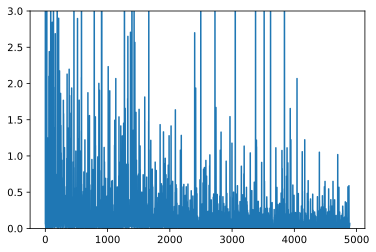

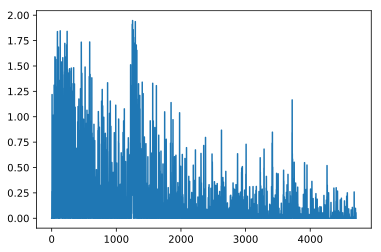

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

xx0 = list(range(len(loss_history[0])))
xx1 = list(range(len(loss_history[1])))

plt.plot(xx0, loss_history[0])
plt.ylim(0.0,3.0)
plt.show()

plt.plot(xx1, loss_history[1])
plt.show()